# OONI Data Analysis - Internet Blocking Detection

## Introduction

The Open Observatory of Network Interference (OONI) is a global initiative dedicated to monitoring Internet censorship and network interference. This notebook analyzes OONI data to identify instances of Internet blocking by implementing analytical techniques to assess the likelihood that observed anomalies are genuine cases of blocking.

## 1. Data Preparation

In this section, we'll load the provided CSV file using chunking and conduct an initial exploration of the dataset to understand its structure.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import warnings
from collections import Counter, defaultdict
from pathlib import Path
import time

warnings.filterwarnings('ignore', category=FutureWarning)

# Setting plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# For better display of dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Loading the Dataset with Chunking

Since the dataset is extremely large (88GB with over 128 million rows), we'll use pandas' chunking functionality to process it incrementally without loading everything into memory at once.

In [2]:
# File path
file_path = '202505-ooni-hpi-sample.csv'

# Check file size
file_size_gb = os.path.getsize(file_path) / (1024**3)
print(f"File size: {file_size_gb:.2f} GB")

# Define chunk size (adjust based on your system's memory)
chunk_size = 100000  # Process 100,000 rows at a time

FileNotFoundError: [Errno 2] No such file or directory: '202505-ooni-hpi-sample.csv'

### Initial Dataset Exploration

We'll process the file in chunks to gather basic information about the dataset structure.

In [4]:
# Initialize variables to store dataset information
total_rows = 0
columns = []
data_types = {}
missing_values = {}
missing_percentage = {}
sample_rows = []

# Process the CSV file in chunks
print("Processing the CSV file in chunks...")
for chunk_num, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
    # For the first chunk, capture columns and start collecting stats
    if chunk_num == 0:
        columns = chunk.columns.tolist()
        
        # Initialize counters using the first chunk
        for col in columns:
            data_types[col] = str(chunk[col].dtype)
            missing_values[col] = chunk[col].isnull().sum()
            missing_percentage[col] = (chunk[col].isnull().sum() / len(chunk) * 100)
        
        # Save the first few rows as a sample
        sample_rows = chunk.head(5).copy()
    else:
        # Update missing value stats with each new chunk
        for col in columns:
            missing_values[col] += chunk[col].isnull().sum()
            missing_percentage[col] = (missing_values[col] / (total_rows + len(chunk)) * 100)
    
    # Update total row count
    total_rows += len(chunk)
    
    # Print progress every 10 chunks
    if chunk_num % 10 == 0:
        print(f"Processed {total_rows:,} rows so far...")
    
    # Optional: limit the number of chunks for initial exploration
    '''
    if chunk_num >= 50:  # Process first ~5 million rows for initial exploration
        print("Reached chunk limit for initial exploration.")
        break
    '''

Processing the CSV file in chunks...
Processed 100,000 rows so far...
Processed 1,100,000 rows so far...
Processed 2,100,000 rows so far...
Processed 3,100,000 rows so far...
Processed 4,100,000 rows so far...
Processed 5,100,000 rows so far...
Processed 6,100,000 rows so far...
Processed 7,100,000 rows so far...
Processed 8,100,000 rows so far...
Processed 9,100,000 rows so far...
Processed 10,100,000 rows so far...
Processed 11,100,000 rows so far...
Processed 12,100,000 rows so far...
Processed 13,100,000 rows so far...
Processed 14,100,000 rows so far...
Processed 15,100,000 rows so far...
Processed 16,100,000 rows so far...
Processed 17,100,000 rows so far...
Processed 18,100,000 rows so far...
Processed 19,100,000 rows so far...
Processed 20,100,000 rows so far...
Processed 21,100,000 rows so far...
Processed 22,100,000 rows so far...
Processed 23,100,000 rows so far...
Processed 24,100,000 rows so far...
Processed 25,100,000 rows so far...
Processed 26,100,000 rows so far...
Pro

### Dataset Overview

Let's examine the basic structure of the dataset.

In [5]:
# Display basic information about the dataset
print("\n=== DATASET OVERVIEW ===")
print(f"Dataset has {total_rows:,} rows processed (out of ~128,683,405 total)")
print(f"Number of columns: {len(columns)}")

# Display the sample rows
print("\n=== SAMPLE ROWS ===")
sample_rows


=== DATASET OVERVIEW ===
Dataset has 128,683,208 rows processed (out of ~128,683,405 total)
Number of columns: 78

=== SAMPLE ROWS ===


,measurement_uid,input,measurement_start_time,software_name,software_version,test_name,test_version,bucket_date,probe_asn,probe_cc,probe_as_org_name,probe_as_cc,probe_as_name,network_type,platform,origin,resolver_ip,resolver_asn,resolver_cc,resolver_as_org_name,resolver_as_cc,hostname,ip,port,ip_asn,ip_as_org_name,ip_as_cc,ip_cc,ip_is_bogon,dns_query_type,dns_failure,dns_engine,dns_engine_resolver_address,dns_answer_type,dns_answer,dns_answer_asn,dns_answer_as_org_name,dns_t,tcp_failure,tcp_success,tcp_t,tls_failure,tls_server_name,tls_version,tls_cipher_suite,tls_is_certificate_valid,tls_end_entity_certificate_fingerprint,tls_end_entity_certificate_subject,tls_end_entity_certificate_subject_common_name,tls_end_entity_certificate_issuer,tls_end_entity_certificate_issuer_common_name,tls_end_entity_certificate_san_list,tls_end_entity_certificate_not_valid_after,tls_end_entity_certificate_not_valid_before,tls_certificate_chain_length,tls_handshake_read_count,tls_handshake_write_count,tls_handshake_read_bytes,tls_handshake_write_bytes,tls_handshake_last_operation,tls_handshake_time,tls_t,http_request_url,http_network,http_alpn,http_failure,http_request_body_length,http_request_method,http_runtime,http_response_body_length,http_response_body_is_truncated,http_response_status_code,http_response_header_location,http_response_header_server,http_request_redirect_from,http_request_body_is_truncated,http_t,probe_analysis
0,20250430235916.855335_AM_facebookmessenger_c3e...,\N,2025-05-01 00:00:01.000,ooniprobe-cli,3.9.2,facebook_messenger,0.2.0,2025-04-30T23,49800,AM,GNC-Alfa CJSC,AM,20160401,unknown,unknown,unknown,91.218.4.130,51225,AM,Armenian internet traffic exchange 'Armix' fou...,AM,star.c10r.facebook.com,157.240.9.18,443,32934,"Facebook, Inc.",US,BG,0,A,\N,system,NaN,A,157.240.9.18,32934,"Facebook, Inc.",0.003277061,\N,1,0.030956731,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,[],\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,20250430235916.855335_AM_facebookmessenger_c3e...,\N,2025-05-01 00:00:01.000,ooniprobe-cli,3.9.2,facebook_messenger,0.2.0,2025-04-30T23,49800,AM,GNC-Alfa CJSC,AM,20160401,unknown,unknown,unknown,91.218.4.130,51225,AM,Armenian internet traffic exchange 'Armix' fou...,AM,star.c10r.facebook.com,2a03:2880:f028:11:face:b00c:0:2,\N,32934,"Facebook, Inc.",US,IE,0,AAAA,\N,system,NaN,AAAA,2a03:2880:f028:11:face:b00c:0:2,32934,"Facebook, Inc.",0.003277061,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,[],\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,20250430235916.855335_AM_facebookmessenger_c3e...,\N,2025-05-01 00:00:01.000,ooniprobe-cli,3.9.2,facebook_messenger,0.2.0,2025-04-30T23,49800,AM,GNC-Alfa CJSC,AM,20160401,unknown,unknown,unknown,91.218.4.130,51225,AM,Armenian internet traffic exchange 'Armix' fou...,AM,stun.fbsbx.com,157.240.9.8,\N,32934,"Facebook, Inc.",US,BG,0,A,\N,system,NaN,A,157.240.9.8,32934,"Facebook, Inc.",0.06152489,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,[],\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,20250430235916.855335_AM_facebookmessenger_c3e...,\N,2025-05-01 00:00:01.000,ooniprobe-cli,3.9.2,facebook_messenger,0.2.0,2025-04-30T23,49800,AM,GNC-Alfa CJSC,AM,20160401,unknown,unknown,unknown,91.218.4.130,51225,AM,Armenian internet traffic exchange 'Armix' fou...,AM,stun.fbsbx.com,2a03:2880:f028:7:face:b00c:0:24d9,\N,32934,"Facebook, Inc.",US,IE,0,AAAA,\N,system,NaN,AAAA,2a03:2880:f028:7:face:b00c:0:24d9,32934,"Facebook, Inc.",0.06152489,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,[],\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,20250430235916.855335_AM_facebookmessenger_c3e...,\N,2025-05-01 00:00:01.000,ooniprobe-cli,3.9.2,facebook_messenger,0.2.0,2025-04-30T23,49800,AM,GNC-Alfa CJSC,AM,20160401,unknown,unknown,unknown,91.218.4.130,51225,AM,Armenian internet traffic exchange 'Armix' fou...,AM,b-graph.facebook.com,157.240.9.35,443,32934,"Facebook, Inc.",US,BG,0,A,\N,system,NaN,A,157.240.9.35,3

### Column Information

Here we can see the data types and missing value statistics for each column.

In [6]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Display column information (full version)
print("\n=== COMPLETE COLUMN INFORMATION ===")
col_info = pd.DataFrame({
    'Data Type': data_types,
    'Missing Values': missing_values,
    'Missing Percentage': {k: f"{v:.2f}%" for k, v in missing_percentage.items()}
})
col_info


=== COMPLETE COLUMN INFORMATION ===


,Data Type,Missing Values,Missing Percentage
measurement_uid,object,0,0.00%
input,object,0,0.00%
measurement_start_time,object,0,0.00%
software_name,object,0,0.00%
software_version,object,0,0.00%
test_name,object,0,0.00%
test_version,object,0,0.00%
bucket_date,object,0,0.00%
probe_asn,int64,0,0.00%
probe_cc,object,11194,0.01%


### Key Columns Identification

Let's identify potential timestamp and geographic columns for further analysis.

In [8]:
# Identify potential timestamp and geographic columns
timestamp_cols = [col for col in columns if 'time' in col.lower() or 'date' in col.lower()]
geo_cols = [col for col in columns if any(term in col.lower() for term in 
                                        ['country', 'location', 'geo', 'region', 'city', '_cc'])]

print("\n=== POTENTIAL KEY COLUMNS ===")
if timestamp_cols:
    print(f"Potential timestamp columns: {timestamp_cols}")
if geo_cols:
    print(f"Potential geographical columns: {geo_cols}")


=== POTENTIAL KEY COLUMNS ===
Potential timestamp columns: ['measurement_start_time', 'bucket_date', 'tls_handshake_time', 'http_runtime']
Potential geographical columns: ['probe_cc', 'probe_as_cc', 'resolver_cc', 'resolver_as_cc', 'ip_as_cc', 'ip_cc', 'http_response_header_location']


### Categorical Column Analysis

Below is a function that allows us to analyze categorical columns by processing the file in chunks.

In [9]:
# Function to analyze categorical columns in chunks
def analyze_categorical_chunks(file_path, columns_to_analyze, chunk_size=100000, max_chunks=50):
    """Analyze categorical columns by processing file in chunks"""
    value_counts = {col: {} for col in columns_to_analyze}
    
    for chunk_num, chunk in enumerate(pd.read_csv(file_path, usecols=columns_to_analyze, 
                                                chunksize=chunk_size)):
        for col in columns_to_analyze:
            # Update value counts dictionary
            counts = chunk[col].value_counts().to_dict()
            for val, count in counts.items():
                if val in value_counts[col]:
                    value_counts[col][val] += count
                else:
                    value_counts[col][val] = count
        
        if chunk_num >= max_chunks:
            break
    
    # Convert to DataFrames and sort
    results = {}
    for col in columns_to_analyze:
        results[col] = pd.Series(value_counts[col]).sort_values(ascending=False)
    
    return results

### Categorical Analysis Example

Here's an example of how to use the categorical analysis function. You can uncomment and customize this cell to analyze specific columns.

In [10]:
# Select a few key categorical columns to analyze
# Uncomment and run this cell when you're ready to analyze specific columns


if geo_cols:
    categorical_results = analyze_categorical_chunks(
        file_path, 
        geo_cols[:2],  # Analyze first two geographic columns
        chunk_size=chunk_size,
        max_chunks=50
    )
    
    for col, counts in categorical_results.items():
        print(f"\n=== TOP VALUES FOR {col} ===")
        print(counts.head(20))  # Show top 20 values



=== TOP VALUES FOR probe_cc ===
US    1073165
BR     416511
VE     381862
RU     284585
DE     282100
FR     214206
GB     170471
CA     165808
NL     122163
BE     119851
TW     114710
IN     108103
MX     104538
TR      71477
MY      64099
ES      59539
VN      57826
ID      53063
IT      48558
NZ      42870
dtype: int64

=== TOP VALUES FOR probe_as_cc ===
US    1125208
BR     404376
VE     381862
RU     284585
DE     280408
FR     212500
GB     207192
CA     153883
NL     125627
BE     119851
TW     113935
MX     104538
IN      94858
TR      70271
MY      64099
ES      58368
VN      57826
IT      48558
ID      47532
NZ      42870
dtype: int64


In [7]:
# Cell to find all unique values in probe_analysis and other important columns using chunks

# Initialize sets to store unique values
unique_values = {
    'probe_analysis': set(),
    'dns_failure': set(),
    'tcp_failure': set(),
    'http_failure': set(),
    'tls_failure': set()
}

# Columns to analyze
columns_to_analyze = list(unique_values.keys())

# Process the CSV file in chunks
print("Analyzing unique values in columns across the entire dataset...")
total_rows = 0

# Use the same CSV file path and chunk size as in your existing code
for chunk_num, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, usecols=columns_to_analyze + ['measurement_uid'], low_memory=False)):
    # Update unique values for each column
    for col in columns_to_analyze:
        if col in chunk.columns:
            # Get unique non-null values from this chunk and add to our set
            chunk_unique = set(val for val in chunk[col].unique() if pd.notna(val))
            unique_values[col].update(chunk_unique)
    
    # Update total row count
    total_rows += len(chunk)
    
    # Print progress every 10 chunks
    if chunk_num % 10 == 0:
        print(f"Processed {total_rows:,} rows so far...")

# Convert sets to sorted lists for display
for col in columns_to_analyze:
    unique_values[col] = sorted(list(unique_values[col]))

# Display results
print(f"\nAnalysis complete. Processed {total_rows:,} total rows.")

# Display unique values for each column
for col in columns_to_analyze:
    print(f"\nUnique values in {col} column ({len(unique_values[col])} values):")
    for value in unique_values[col]:
        print(f"- {value}")
    
    # Optional: save to file if there are many values
    if len(unique_values[col]) > 20:
        print(f"There are many unique values. First 20 shown above.")
        
        # Save all values to a text file
        with open(f"{col}_unique_values.txt", 'w') as f:
            for value in unique_values[col]:
                f.write(f"{value}\n")
        print(f"All values saved to {col}_unique_values.txt")

Analyzing unique values in columns across the entire dataset...
Processed 100,000 rows so far...
Processed 1,100,000 rows so far...
Processed 2,100,000 rows so far...
Processed 3,100,000 rows so far...
Processed 4,100,000 rows so far...
Processed 5,100,000 rows so far...
Processed 6,100,000 rows so far...
Processed 7,100,000 rows so far...
Processed 8,100,000 rows so far...
Processed 9,100,000 rows so far...
Processed 10,100,000 rows so far...
Processed 11,100,000 rows so far...
Processed 12,100,000 rows so far...
Processed 13,100,000 rows so far...
Processed 14,100,000 rows so far...
Processed 15,100,000 rows so far...
Processed 16,100,000 rows so far...
Processed 17,100,000 rows so far...
Processed 18,100,000 rows so far...
Processed 19,100,000 rows so far...
Processed 20,100,000 rows so far...
Processed 21,100,000 rows so far...
Processed 22,100,000 rows so far...
Processed 23,100,000 rows so far...
Processed 24,100,000 rows so far...
Processed 25,100,000 rows so far...
Processed 26

### Revised Data Cleaning Categories for OONI Analysis

#### Analysis of `probe_analysis` Values for Data Cleaning

| Value | Description | Category |
|-------|-------------|----------|
| `\N` | Missing values | **Anomaly** - Requires further analysis with other columns |
| `dns` | DNS resolution failures | **Remove** - Technical failure rather than censorship |
| `false` | Test passed successfully | **Accessible** - Website/service is definitely accessible |
| `http-diff` | Content differences detected | **Confirmed Blocked** - Strong indicator of content manipulation/censorship |
| `http-failure` | HTTP connection failures | **Anomaly** - Requires context from `http_failure` column |
| `tcp_ip` | TCP/IP level connectivity issues | **Anomaly** - Requires context from `tcp_failure` column |

#### Analysis of `dns_failure` Values for Data Cleaning

| Category | Values | 
|----------|--------|
| **Remove** (Technical Failures) | `address_family_not_supported`, `address_not_available`, `connection_aborted`, `connection_refused` (when randomly distributed), `connection_reset` (when randomly distributed), `no_buffer_space`, `permission_denied`, `host_unreachable`, `network_unreachable`, `android_dns_cache_no_data`, `timed_out` (randomly distributed), `generic_timeout_error` (randomly distributed), `internal_error`, `invalid_record`, All `TRANSPORT_PARAMETER_ERROR` values, `ssl_failed_handshake`, `ssl_invalid_certificate`, `ssl_invalid_hostname`, `ssl_unknown_authority` (when random), `\N` (when other columns show success) |
| **Confirmed Blocked** | `dns_bogon_error` (responses with private/reserved IPs), `dns_reply_with_wrong_query_id` (DNS poisoning), `dns_nxdomain_error` (for globally popular domains), `dns_refused_error` (when pattern exists by country/ISP) |
| **Anomaly** | `dns_no_answer` (with no other errors), `dns_server_misbehaving`, `dns_servfail_error`, `dns_temporary_failure`, `eof_error`, `timed_out` (when pattern exists by content type), `connection_refused` (when pattern exists by content type) |
| **Accessible** | No DNS failure reported (empty field with successful resolution) |

#### Analysis of `tcp_failure` Values for Data Cleaning

| Category | Values | 
|----------|--------|
| **Remove** (Technical Failures) | `address_family_not_supported`, `address_not_available`, `bad_file_descriptor`, `invalid_argument`, `interrupted`, `not_connected`, `no_buffer_space`, `network_down`, `permission_denied`, Errors containing: `cannot allocate memory`, `cannot assign requested address`, `socket en una red no accesible`, `\N` (when other columns show success) |
| **Confirmed Blocked** | `connection_refused` (when consistent patterns exist by content category and country), `connection_reset` (when consistent for politically sensitive content) |
| **Anomaly** | `connection_reset` (without clear pattern), `connection_aborted`, `timed_out`, `generic_timeout_error`, `network_unreachable` (requires pattern analysis), `host_unreachable` (without clear pattern), `true` (requires examination of other fields) |
| **Accessible** | No TCP failure reported (empty field with successful connection) |

#### Analysis of `http_failure` Values for Data Cleaning

| Category | Values | 
|----------|--------|
| **Remove** (Technical Failures) | `address_family_not_supported`, `address_not_available`, `bad_file_descriptor`, `android_dns_cache_no_data`, `dns_temporary_failure`, `dns_server_misbehaving` (random), `no_buffer_space`, `permission_denied`, `not_connected`, `operation_would_block`, `ssl_invalid_certificate` (when consistent across clients), `ssl_invalid_hostname` (random), All `TRANSPORT_PARAMETER_ERROR` failures, `\N` (when other columns show success) |
| **Confirmed Blocked** | `access_denied`, `http_empty_location_header` with specific redirects, `ssl_error: error:1404B419:SSL routines:ST_CONNECT:tlsv1 alert access denied`, `tls_illegal_parameter` (when pattern exists by content), HTTP status codes: 451, 403 (with block page content) |
| **Anomaly** | `connection_refused` (with patterns), `connection_reset` (with patterns), `dns_nxdomain_error` (for known domains), `dns_no_answer` (with patterns), `connection_aborted`, `eof_error`, `http_timeout`, `generic_timeout_error`, `timed_out` (with patterns), `http_too_many_redirects`, `ssl_unknown_authority` (with patterns), HTTP status codes: 301/302 (with suspicious redirects) |
| **Accessible** | `ok` value, HTTP status codes: 200, 301/302 (with normal redirects), 404 (legitimate not found) |

#### Analysis of `tls_failure` Values for Data Cleaning

| Category | Values | 
|----------|--------|
| **Remove** (Technical Failures) | `address_not_available`, `no_buffer_space`, `host_unreachable` (random), `interrupted`, `internal_error`, `not_connected`, `permission_denied`, All `TRANSPORT_PARAMETER_ERROR` errors, `ssl_invalid_certificate` (when consistent across clients/random), `\N` (when other columns show success) |
| **Confirmed Blocked** | `access_denied` with TLS alerts, `tls_illegal_parameter` (when pattern exists by content/country), `tls_handshake_failure` (when consistent for specific domain categories), TLS alert values: 40, 42, 47, 50, 51 (with consistent patterns) |
| **Anomaly** | `connection_reset` (during TLS handshake), `connection_refused` (with patterns), `ssl_failed_handshake`, `eof_error` (during TLS handshake), `timed_out`, `generic_timeout_error` (with patterns), `ssl_invalid_hostname` (with patterns), `ssl_unknown_authority` (for globally trusted sites) |
| **Accessible** | No TLS failure reported (empty field with successful TLS handshake) |

### Implementation Guide

For effective data cleaning:

1. **First pass**: Remove all entries categorized as "Remove" (technical failures)
2. **Second pass**: Flag entries as "Confirmed Blocked" for censorship analysis
3. **Third pass**: Mark "Anomaly" entries for deeper analysis, potentially with:
   - Cross-referencing by country, ISP, and content type
   - Temporal analysis (are patterns consistent over time?)
   - Comparison with control measurements
4. **Fourth pass**: Use "Accessible" entries as control group for comparison

<Figure size 1500x1000 with 0 Axes>

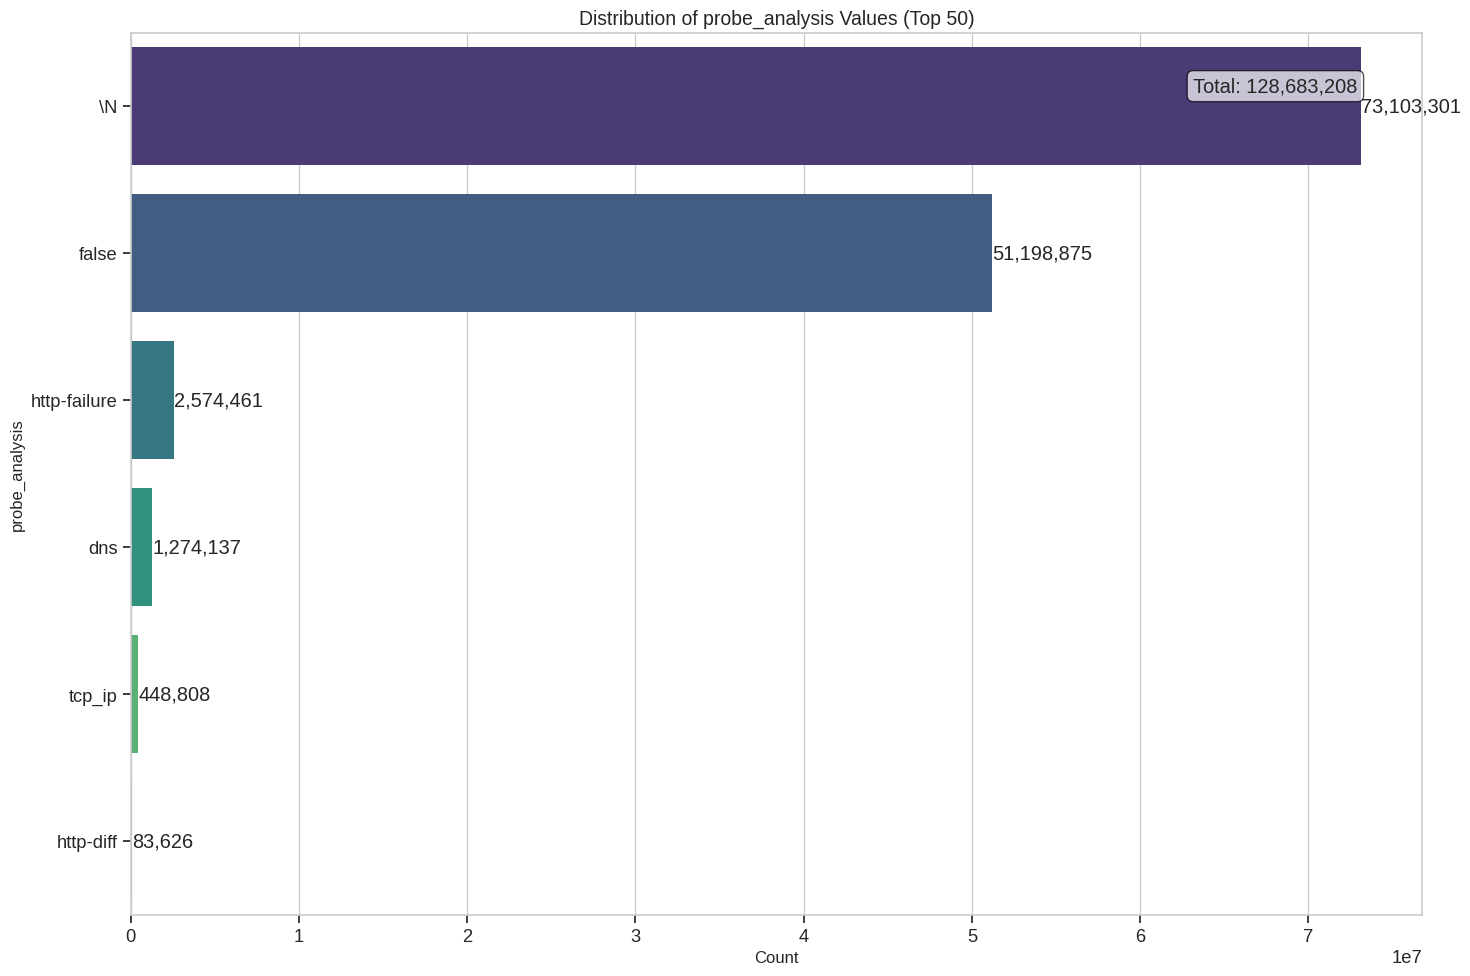

<Figure size 1500x1000 with 0 Axes>

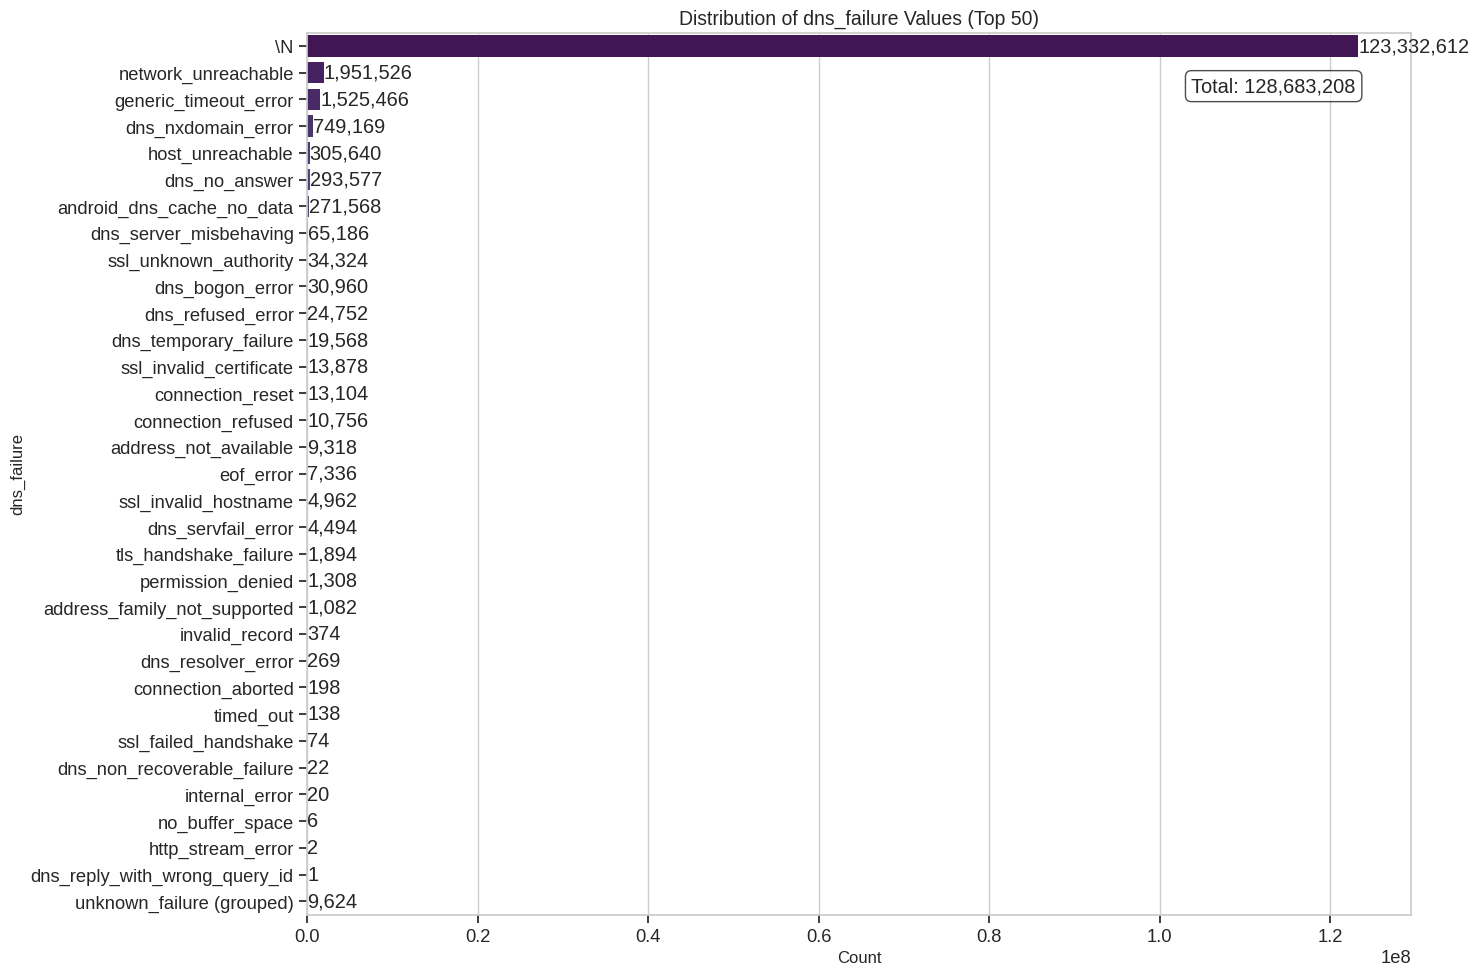

<Figure size 1500x1000 with 0 Axes>

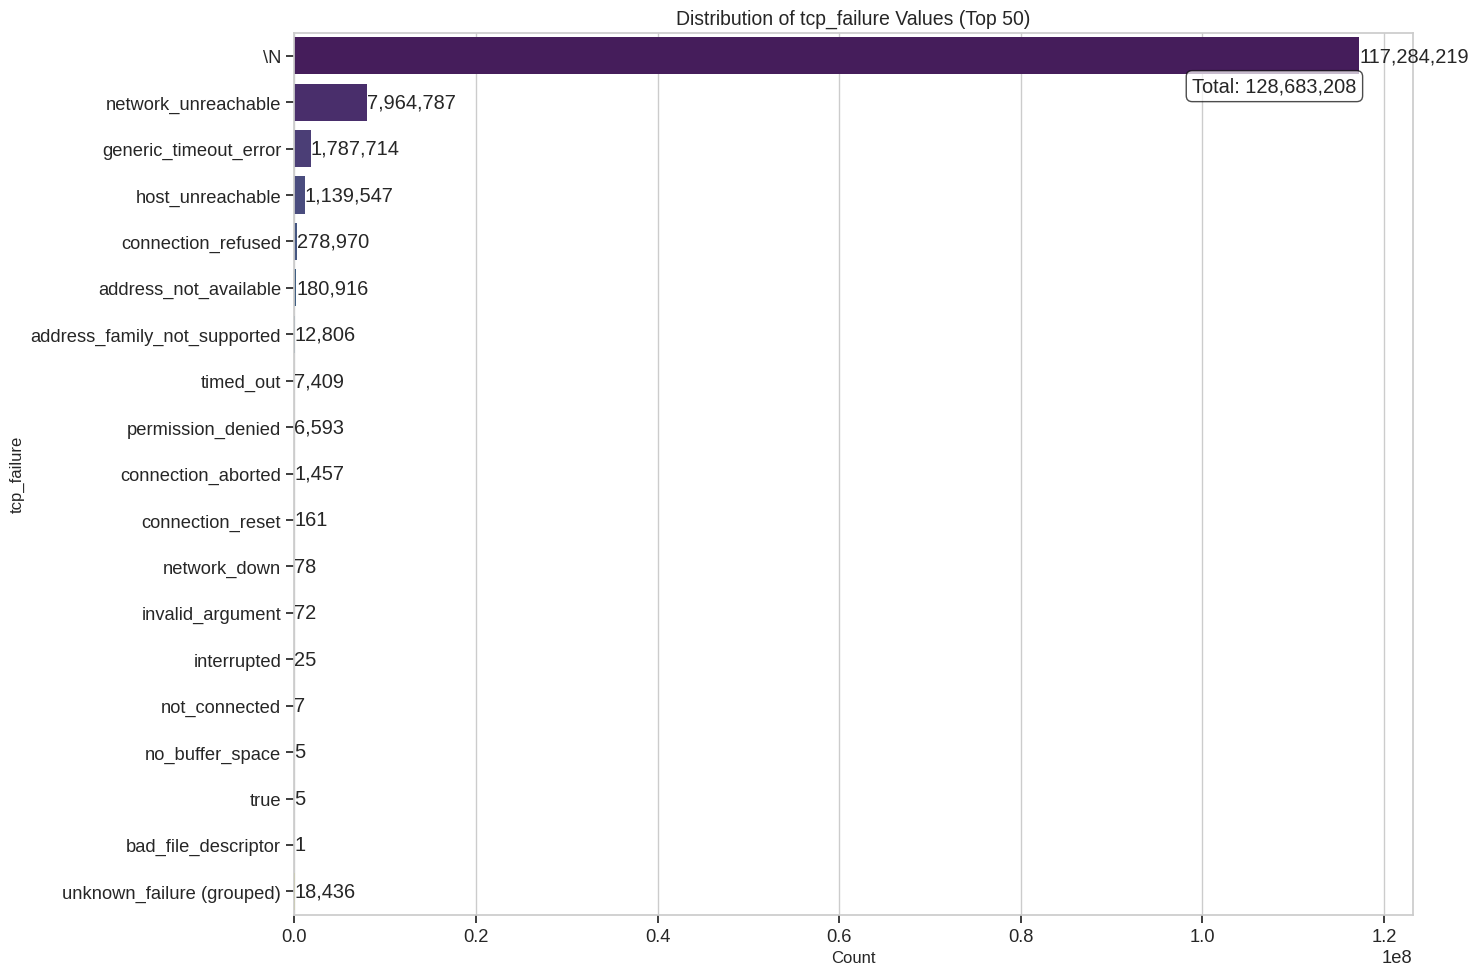

<Figure size 1500x1000 with 0 Axes>

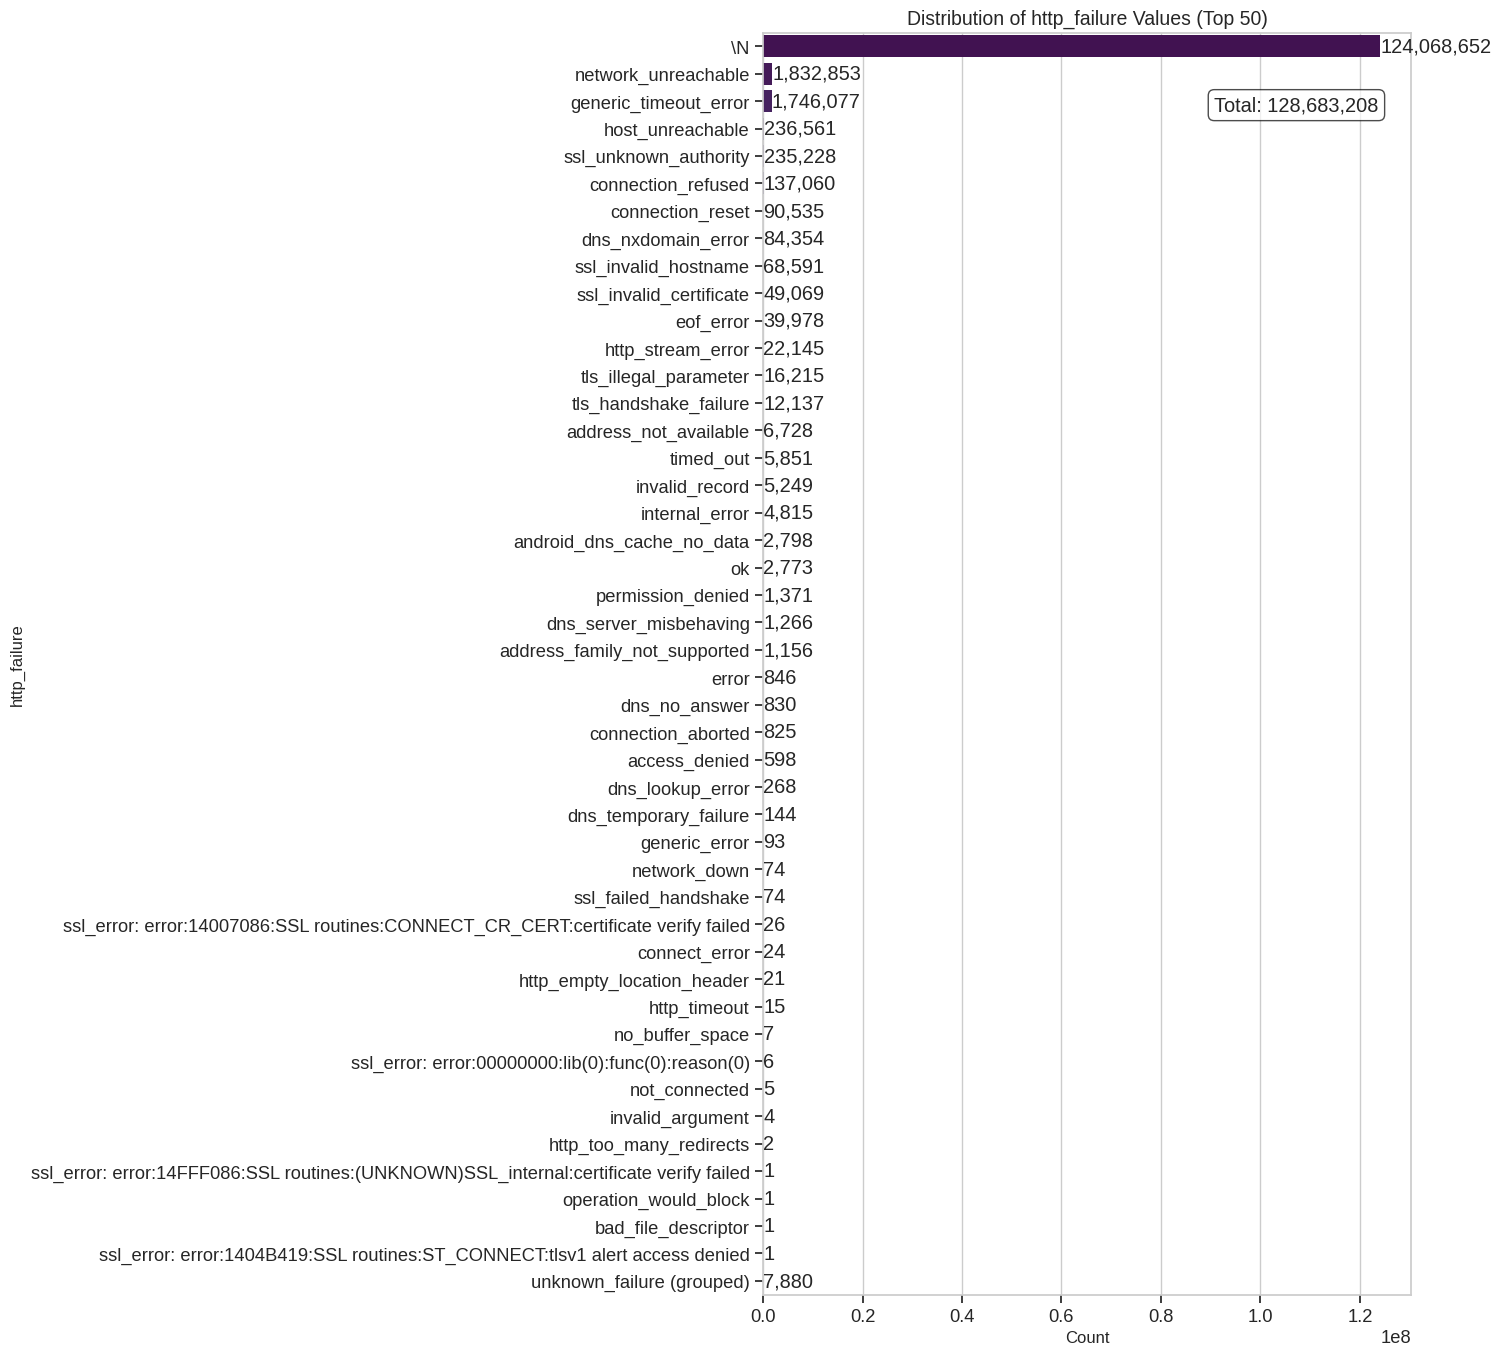

<Figure size 1500x1000 with 0 Axes>

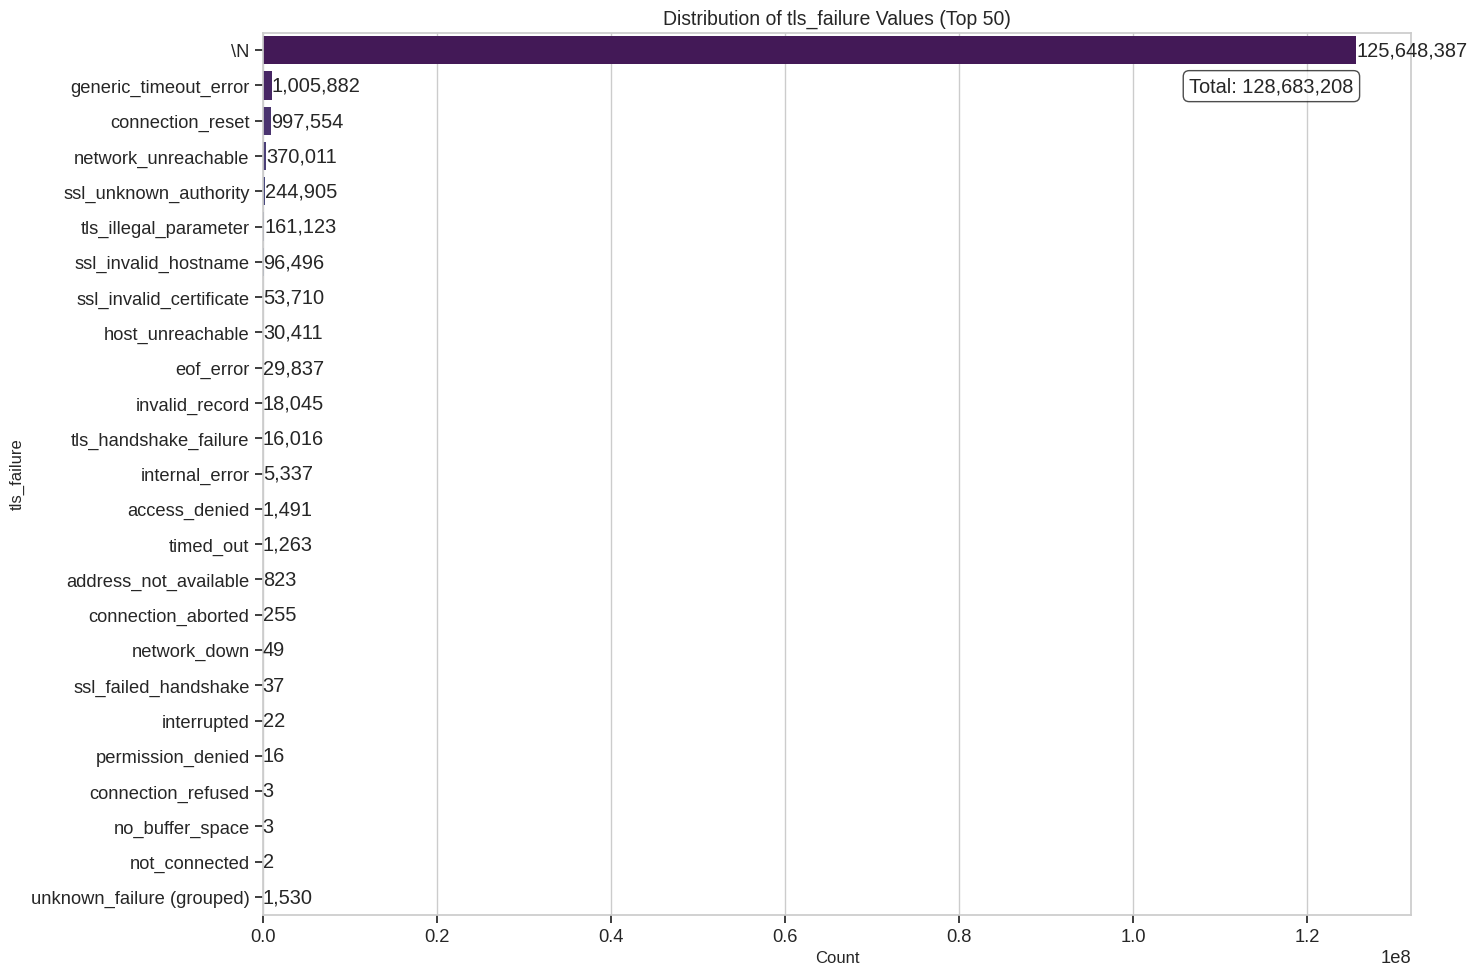

In [3]:
def plot_categorical_distributions(data_file, columns, chunk_size=100000, top_n=50, figsize=(15, 10)):
    """
    Plot distributions of unique values in categorical columns, processing data in chunks.
    Creates separate plots for each column to accommodate more values.
    
    Parameters:
    -----------
    data_file : str
        Path to the CSV file
    columns : list
        List of categorical column names to analyze
    chunk_size : int
        Size of chunks to process at a time
    top_n : int
        Number of top values to display (excluding grouped categories)
    figsize : tuple
        Figure size for each individual plot
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter
    
    # Initialize counters for each column
    counters = {col: Counter() for col in columns}
    
    # Process data in chunks
    for chunk in pd.read_csv(data_file, chunksize=chunk_size):
        for col in columns:
            if col in chunk.columns:
                # Count values in this chunk
                col_values = chunk[col].fillna('\\N').astype(str)
                
                # Group unknown_failures
                grouped_values = []
                for val in col_values:
                    if val.startswith('unknown_failure'):
                        grouped_values.append('unknown_failure (grouped)')
                    else:
                        grouped_values.append(val)
                
                # Update counter for this column
                counters[col].update(grouped_values)
    
    # Create individual plots for each column
    for col in columns:
        counter = counters[col]
        
        # Create a new figure for this column
        plt.figure(figsize=figsize)
        
        # Prepare data for plotting
        items = counter.most_common()
        
        # Separate common categories and the "unknown_failure" group
        unknown_failure_item = None
        common_items = []
        
        for item in items:
            if item[0] == 'unknown_failure (grouped)':
                unknown_failure_item = item
            else:
                common_items.append(item)
        
        # Take top N common items (excluding grouped unknown_failures)
        top_items = common_items[:top_n]
        
        # Add back unknown_failure group if it exists
        if unknown_failure_item:
            top_items.append(unknown_failure_item)
        
        # Extract labels and counts
        labels, counts = zip(*top_items) if top_items else ([], [])
        
        # Adjust figure height based on number of items
        plt.figure(figsize=(figsize[0], min(30, max(10, len(labels) * 0.3))))
        
        # Plot
        ax = sns.barplot(x=list(counts), y=list(labels), palette='viridis')
        plt.title(f'Distribution of {col} Values (Top {top_n})', fontsize=14)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel(col, fontsize=12)
        
        # Add count text on bars
        for j, count in enumerate(counts):
            plt.text(count + 0.1, j, f"{count:,}", va='center')
        
        # Add total
        total = sum(counter.values())
        plt.text(0.95, 0.95, f'Total: {total:,}', 
                transform=ax.transAxes, 
                ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
    
    return counters

# Example usage
categorical_columns = ['probe_analysis', 'dns_failure', 'tcp_failure', 'http_failure', 'tls_failure']
counters = plot_categorical_distributions(file_path, categorical_columns)

# To access the counts for a specific column
# print(counters['http_failure'].most_common(10))

## OONI Dataset Initial Exploration Summary

### Dataset Overview

The OONI (Open Observatory of Network Interference) dataset is an extensive collection of internet censorship measurements with the following characteristics:

- **Size**: Approximately 88GB containing over 128 million rows (128.683.405 to be exact)
- **Structure**: 78 columns capturing various aspects of network measurements
- **Processing Approach**: Used chunking technique (100,000 rows per chunk) to handle the large file size efficiently

### Dataset Structure

#### Key Dimensions

The dataset contains several types of columns that provide insights into various aspects of internet measurements:

1. **Measurement Identifiers**:
   - `measurement_uid`: Unique identifier for each measurement
   - `test_name`, `test_version`: Type and version of the test performed

2. **Temporal Information**:
   - `measurement_start_time`: When the measurement was taken
   - `bucket_date`: Temporal grouping of measurements
   - `tls_handshake_time`, `http_runtime`: Performance timing metrics

3. **Geographic Information**:
   - `probe_cc`: Country where the probe is located (most common: US, BR, VE, RU, DE)
   - `probe_as_cc`, `resolver_cc`, `ip_cc`: Country codes for various network elements
   - Distribution shows measurements primarily from North America, Europe, and parts of Asia

4. **Network Infrastructure**:
   - `probe_asn`, `resolver_asn`, `ip_asn`: Autonomous System Numbers
   - `resolver_ip`, `ip`: IP addresses used in measurements
   - `probe_as_org_name`, `ip_as_org_name`: Organizations operating the networks

5. **Test Results**:
   - DNS-related columns (`dns_query_type`, `dns_answer`, `dns_failure`)
   - TCP connection information (`tcp_success`, `tcp_failure`)
   - TLS/HTTPS details (`tls_version`, `tls_cipher_suite`, `tls_failure`)
   - HTTP response data (`http_response_status_code`, `http_response_body_length`)

#### Data Quality

- Most columns have good completeness with low rates of missing values
- Notable exceptions include `dns_engine_resolver_address` (41.81% missing)
- Categorical columns like `probe_cc` show expected distributions with major internet-using countries represented
- `\N` is used as a null value indicator in many columns

### Initial Findings

- The dataset contains extensive measurements from 100+ countries with the United States, Brazil, and Venezuela having the highest representation
- The data includes various types of network tests with detailed timing metrics
- Most measurements appear to be related to connectivity testing, with Facebook services appearing frequently in the sample rows
- Geographic distribution reflects global internet usage patterns with strong representation from North America, Europe, South America, and parts of Asia

This initial exploration provides a solid foundation for more detailed analysis of internet censorship patterns using the OONI dataset.

## 2. Data Cleaning

In this section, we'll clean the OONI dataset by handling missing values and normalizing categorical variables to ensure consistency in our analysis.



### 1. Basic Data Cleaning Functions

These functions handle fundamental data cleaning tasks such as converting null indicators, handling missing values, and normalizing categorical variables.

Based on our analysis, we'll implement these strategies for handling missing values:

1. **Drop columns** with extremely high missing rates (e.g., >80%)
2. **Fill missing values** in columns with moderate missing rates (1-80%)
3. **Keep columns** with low missing rates (<1%)

For fill strategies, we'll use appropriate methods based on the data type:
- Categorical data: fill with the most frequent value or a special "Unknown" category
- Numerical data: fill with median values
- Timestamps: fill with the median or previous/next values

In [3]:
def convert_null_indicators(chunk):
    # Convert special null indicators (\N) to NaN for consistent processing
    return chunk.replace('\\N', np.nan)


def handle_missing_values(chunk, columns_to_drop, categorical_columns_to_fill, 
                          numerical_columns_to_fill, categorical_fill_values=None):
    """
    Process a chunk to handle missing values according to predetermined strategies
    
    Args:
        chunk: pandas DataFrame chunk
        columns_to_drop: list of columns to drop
        categorical_columns_to_fill: list of categorical columns to fill
        numerical_columns_to_fill: list of numerical columns to fill
        categorical_fill_values: dict of {column_name: fill_value} (if None, will use 'unknown')
    
    Returns:
        Processed DataFrame chunk
    """
    # Make a copy to avoid modifying the original
    processed_chunk = chunk.copy()
    
    # 1. Drop columns with high missing rates
    processed_chunk = processed_chunk.drop(columns=columns_to_drop, errors='ignore')
    
    # 2. Fill missing values in categorical columns
    if categorical_fill_values is None:
        categorical_fill_values = {col: 'unknown' for col in categorical_columns_to_fill}
        
    for col in categorical_columns_to_fill:
        if col in processed_chunk.columns:
            processed_chunk[col] = processed_chunk[col].fillna(categorical_fill_values[col])
    
    # 3. Fill missing values in numerical columns with median
    for col in numerical_columns_to_fill:
        if col in processed_chunk.columns:
            # Convert to numeric first to ensure proper handling
            processed_chunk[col] = pd.to_numeric(processed_chunk[col], errors='coerce')
            # Use the median of the current chunk
            median_value = processed_chunk[col].median()
            if pd.notnull(median_value):
                processed_chunk[col] = processed_chunk[col].fillna(median_value)
    
    return processed_chunk


def normalize_country_codes(chunk):
    """
    Standardize country codes in the dataset
    
    This ensures all country codes are uppercase and follow ISO 3166-1 alpha-2 standard
    """
    country_columns = [
        'probe_cc', 'probe_as_cc', 'resolver_cc', 
        'resolver_as_cc', 'ip_as_cc', 'ip_cc'
    ]
    
    for col in country_columns:
        if col in chunk.columns:
            # Convert to uppercase
            chunk[col] = chunk[col].str.upper()
            
            # Handle any known non-standard codes (examples)
            # Add mappings as needed based on data inspection
            code_mapping = {
                'UK': 'GB',  # United Kingdom to Great Britain standard code
                'UNKNOWN': np.nan,
            }
            
            chunk[col] = chunk[col].replace(code_mapping)
    
    return chunk


def normalize_test_names(chunk):
    """
    Standardize test names and types for consistency
    """
    if 'test_name' in chunk.columns:
        # Convert to lowercase and remove special characters
        chunk['test_name'] = chunk['test_name'].str.lower()
        
        # Map variations to standard names (examples)
        test_mapping = {
            'web_connectivity': 'web_connectivity',
            'web connectivity': 'web_connectivity',
            'http_requests': 'http_requests',
            'http requests': 'http_requests',
            'dns_consistency': 'dns_consistency',
            'dns consistency': 'dns_consistency',
            'facebook_messenger': 'facebook_messenger',
            'fb_messenger': 'facebook_messenger',
            'facebook messenger': 'facebook_messenger',
            # Add more mappings as needed
        }
        
        chunk['test_name'] = chunk['test_name'].replace(test_mapping)
    
    return chunk


def normalize_network_types(chunk):
    """
    Standardize network_type values
    """
    if 'network_type' in chunk.columns:
        # Convert to lowercase
        chunk['network_type'] = chunk['network_type'].str.lower()
        
        # Map variations to standard types
        network_mapping = {
            'wifi': 'wifi',
            'wi-fi': 'wifi',
            'wlan': 'wifi',
            'mobile': 'mobile',
            'cellular': 'mobile',
            '3g': 'mobile',
            '4g': 'mobile',
            '5g': 'mobile',
            'lte': 'mobile',
            'ethernet': 'ethernet',
            'lan': 'ethernet',
            'unknown': 'unknown',
            # Add more mappings as needed
        }
        
        chunk['network_type'] = chunk['network_type'].replace(network_mapping)
    
    return chunk


def normalize_categorical_variables(chunk):
    """Apply all normalization functions to standardize categorical variables"""
    chunk = convert_null_indicators(chunk)
    chunk = normalize_country_codes(chunk)
    chunk = normalize_test_names(chunk)
    chunk = normalize_network_types(chunk)
    return chunk

### 2. OONI-Specific Data Quality Functions

OONI data has specific characteristics and potential issues. These functions address them by handling timestamp conversion, numeric type conversion, and anomaly detection.

In [4]:
def convert_timestamps(chunk):
    """
    Convert timestamp columns to proper datetime format
    """
    timestamp_cols = [
        'measurement_start_time', 
        'tls_end_entity_certificate_not_valid_after',
        'tls_end_entity_certificate_not_valid_before'
    ]
    
    for col in timestamp_cols:
        if col in chunk.columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
    
    return chunk


def convert_numeric_columns(chunk):
    """
    Convert numerical columns to proper numeric type
    """
    # Identify columns with timing measurements (_t suffix)
    timing_cols = [col for col in chunk.columns if col.endswith('_t')]
    
    # Add other known numeric columns
    numeric_cols = timing_cols + [
        'probe_asn', 'resolver_asn', 'ip_asn', 'dns_answer_asn',
        'http_response_body_length', 'http_response_status_code',
        'http_request_body_length', 'tls_certificate_chain_length',
        'tls_handshake_read_bytes', 'tls_handshake_write_bytes'
    ]
    
    # Convert each column to numeric
    for col in numeric_cols:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce')
    
    return chunk


def flag_anomalies(chunk):
    """
    Flag potential anomalies in OONI data
    
    Adds boolean flag columns to identify records with unusual or suspicious values
    """
    # Initialize flags dictionary
    flags = {}
    
    # 1. Flag bogon IPs (important for censorship detection)
    if 'ip_is_bogon' in chunk.columns:
        flags['bogon_ip'] = chunk['ip_is_bogon'] == "1"
    
    # 2. Flag country code mismatches (from GeoIP mismatch notebook)
    # Flag country code mismatches that are actually problematic
    if 'probe_cc' in chunk.columns:
        # Convert country codes to proper format
        cc_cols = [col for col in chunk.columns if col.endswith('_cc')]
        for col in cc_cols:
            if col in chunk.columns:
                chunk[col] = chunk[col].astype(str).str.upper()
        
        # 1. Flag resolver in different country than probe (potential DNS hijacking)
        if 'resolver_cc' in chunk.columns:
            flags['resolver_country_mismatch'] = (
                (chunk['probe_cc'] != chunk['resolver_cc']) & 
                (chunk['probe_cc'].notna()) & 
                (chunk['resolver_cc'].notna())
            )
        
        # 2. Flag cases where resolver AS country differs from resolver country
        if 'resolver_cc' in chunk.columns and 'resolver_as_cc' in chunk.columns:
            flags['resolver_as_mismatch'] = (
                (chunk['resolver_cc'] != chunk['resolver_as_cc']) & 
                (chunk['resolver_cc'].notna()) & 
                (chunk['resolver_as_cc'].notna())
            )
        
        # 3. Flag when IP AS country doesn't match IP country (potential GeoIP inconsistency or proxy)
        if 'ip_cc' in chunk.columns and 'ip_as_cc' in chunk.columns:
            flags['ip_as_mismatch'] = (
                (chunk['ip_cc'] != chunk['ip_as_cc']) & 
                (chunk['ip_cc'].notna()) & 
                (chunk['ip_as_cc'].notna())
            )
        
        # 4. Flag suspicious triangulation issues (proxy indicators)
        # This checks if the probe is in country A, resolver in country B, and IP in country C
        if 'resolver_cc' in chunk.columns and 'ip_cc' in chunk.columns:
            flags['triangulation_mismatch'] = (
                (chunk['probe_cc'] != chunk['resolver_cc']) &
                (chunk['resolver_cc'] != chunk['ip_cc']) &
                (chunk['probe_cc'] != chunk['ip_cc']) &
                (chunk['probe_cc'].notna()) &
                (chunk['resolver_cc'].notna()) &
                (chunk['ip_cc'].notna())
            )
    
    # 3. Flag software/platform inconsistencies (from Unusual Combinations notebook)
    if 'software_name' in chunk.columns and 'platform' in chunk.columns:
        # Android software on non-Android platform
        flags['android_platform_mismatch'] = (
            chunk['software_name'].str.contains('android', case=False, na=False) & 
            ~chunk['platform'].str.contains('android', case=False, na=False) & 
            (chunk['platform'].notna())
        )
        
        # iOS software on non-iOS platform
        flags['ios_platform_mismatch'] = (
            chunk['software_name'].str.contains('ios', case=False, na=False) & 
            ~chunk['platform'].str.contains('ios', case=False, na=False) & 
            (chunk['platform'].notna())
        )
    
    # 4. Flag architecture inconsistencies
    if 'platform' in chunk.columns and 'architecture' in chunk.columns:
        # Mobile platforms with unexpected architectures
        flags['mobile_arch_mismatch'] = (
            (
                (chunk['platform'].str.contains('android|ios', case=False, na=False)) & 
                (chunk['architecture'].str.contains('amd64|x86_64', case=False, na=False)) &
                (chunk['architecture'].notna())
            )
        )
    
    # 5. Flag timing anomalies
    if 'dns_t' in chunk.columns:
        # Unusually fast DNS lookups (< 1ms) could indicate measurement issues
        flags['unusually_fast_dns'] = (
            (chunk['dns_t'] < 0.001) & (chunk['dns_t'].notna())
        )
    
    if 'tcp_t' in chunk.columns:
        # Unusually fast TCP connections
        flags['unusually_fast_tcp'] = (
            (chunk['tcp_t'] < 0.001) & (chunk['tcp_t'].notna())
        )
    
    # 6. Flag TLS anomalies
    if 'tls_cipher_suite' in chunk.columns and 'tls_version' in chunk.columns:
        # Flag NULL cipher suites (could indicate censorship or MITM)
        flags['null_cipher'] = chunk['tls_cipher_suite'].str.contains('NULL', na=False)
    
    # 7. Flag HTTP status code anomalies
    if 'http_response_status_code' in chunk.columns:
        # Non-standard status codes
        flags['unusual_status_code'] = chunk['http_response_status_code'].isin([
            403, 404, 451, 502, 503, 504
        ])
    
    # Add all flags to the DataFrame
    for flag_name, flag_values in flags.items():
        chunk[f'flag_{flag_name}'] = flag_values
    
    # Add an overall anomaly flag
    flag_cols = [f'flag_{name}' for name in flags.keys()]
    if flag_cols:
        chunk['has_anomaly'] = chunk[flag_cols].any(axis=1)
    
    return chunk


def summarize_anomalies(chunk):
    """
    Print a summary of flagged anomalies in the data
    """
    flag_cols = [col for col in chunk.columns if col.startswith('flag_')]
    
    if flag_cols:
        print("\n===== Anomaly Summary =====")
        for col in flag_cols:
            flag_count = chunk[col].sum()
            flag_percent = (flag_count / len(chunk)) * 100
            print(f"{col}: {flag_count} records ({flag_percent:.2f}%)")
        
        # Print overall anomaly rate
        if 'has_anomaly' in chunk.columns:
            overall = chunk['has_anomaly'].sum()
            overall_percent = (overall / len(chunk)) * 100
            print(f"\nTotal records with anomalies: {overall} ({overall_percent:.2f}%)")
    
    return chunk

### 3. Main Processing Functions

These functions combine the various cleaning steps to process OONI data efficiently, either in chunks or entire datasets.

In [5]:
def process_chunk(chunk, columns_to_drop=None, categorical_cols_to_fill=None, 
                 numerical_cols_to_fill=None, flag_anomalies_only=False):
    """
    Apply all cleaning steps to a chunk of OONI data
    
    Args:
        chunk: pandas DataFrame chunk
        columns_to_drop: list of columns to drop
        categorical_cols_to_fill: list of categorical columns to fill
        numerical_cols_to_fill: list of numerical columns to fill
        flag_anomalies_only: if True, only flag anomalies without dropping/filling
    
    Returns:
        Processed DataFrame chunk
    """
    # Initialize empty lists if None
    if columns_to_drop is None:
        columns_to_drop = []
    if categorical_cols_to_fill is None:
        categorical_cols_to_fill = []
    if numerical_cols_to_fill is None:
        numerical_cols_to_fill = []
    
    # 1. Basic normalization
    chunk = normalize_categorical_variables(chunk)
    
    # 2. Convert data types
    chunk = convert_timestamps(chunk)
    chunk = convert_numeric_columns(chunk)
    
    # 3. Flag anomalies
    chunk = flag_anomalies(chunk)
    
    # 4. Handle missing values (if not in flag-only mode)
    if not flag_anomalies_only:
        chunk = handle_missing_values(
            chunk, 
            columns_to_drop, 
            categorical_cols_to_fill,
            numerical_cols_to_fill
        )
    
    return chunk


def process_full_dataset(input_file, output_file, chunk_size=100000,
                        columns_to_drop=None, categorical_cols_to_fill=None,
                        numerical_cols_to_fill=None, flag_anomalies_only=False,
                        remove_anomalies=False):
    """
    Process the entire dataset in chunks and save to a new file
    
    Args:
        input_file: Path to the original CSV file
        output_file: Path to save the cleaned CSV file
        chunk_size: Number of rows to process at once
        columns_to_drop: list of columns to drop
        categorical_cols_to_fill: list of categorical columns to fill
        numerical_cols_to_fill: list of numerical columns to fill
        flag_anomalies_only: If True, only flag anomalies without other cleaning
        remove_anomalies: If True, filter out records flagged as anomalies
    """
    # Initialize counters
    total_rows_processed = 0
    chunks_processed = 0
    total_anomalies = 0
    
    # Process the file in chunks
    for i, chunk in enumerate(tqdm(pd.read_csv(input_file, chunksize=chunk_size))):
        # Apply all processing steps
        processed_chunk = process_chunk(
            chunk,
            columns_to_drop,
            categorical_cols_to_fill,
            numerical_cols_to_fill,
            flag_anomalies_only
        )
        
        # Count anomalies
        if 'has_anomaly' in processed_chunk.columns:
            anomalies_in_chunk = processed_chunk['has_anomaly'].sum()
            total_anomalies += anomalies_in_chunk
            
            # Filter out anomalies if requested
            if remove_anomalies:
                processed_chunk = processed_chunk[~processed_chunk['has_anomaly']]
        
        # Save the chunk (append if not the first chunk)
        if i == 0:
            processed_chunk.to_csv(output_file, index=False, mode='w')
        else:
            processed_chunk.to_csv(output_file, index=False, mode='a', header=False)
        
        # Update counters
        total_rows_processed += len(chunk)
        chunks_processed += 1
        
        # Print progress every 10 chunks
        if chunks_processed % 10 == 0:
            print(f"Processed {chunks_processed} chunks ({total_rows_processed:,} rows)")
    
    # Print summary
    print(f"\nCompleted processing {total_rows_processed:,} rows in {chunks_processed} chunks")
    if 'has_anomaly' in processed_chunk.columns:
        anomaly_percent = (total_anomalies / total_rows_processed) * 100
        print(f"Found {total_anomalies:,} anomalies ({anomaly_percent:.2f}%)")
        if remove_anomalies:
            print(f"Removed anomalies from output file")
    print(f"Cleaned data saved to: {output_file}")

### 4. Visualization Functions

These functions help visualize anomalies and timing distributions in the data to better understand data quality issues.

In [6]:
def analyze_flags_in_chunks(csv_file, chunk_size=100000):
    """
    Loads a CSV file in chunks and analyzes the flag distribution
    
    Args:
        csv_file: Path to the cleaned CSV file
        chunk_size: Number of rows to load per chunk
    """
    
    # Initialize counters
    total_rows = 0
    flag_counts = defaultdict(int)
    flag_percentages = {}
    chunks_processed = 0
    anomaly_count = 0
    
    # Create dictionaries for additional statistics
    flag_combinations = defaultdict(int)
    country_anomaly_counts = defaultdict(int)
    test_name_anomaly_counts = defaultdict(int)
    
    print(f"Starting analysis of {csv_file} with chunk size {chunk_size}...")
    
    # Process the file in chunks
    for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
        chunks_processed += 1
        chunk_size_actual = len(chunk)
        total_rows += chunk_size_actual
        
        # Identify flags
        flag_columns = [col for col in chunk.columns if col.startswith('flag_')]
        
        # Count anomalies in this chunk
        if 'has_anomaly' in chunk.columns:
            anomaly_in_chunk = chunk['has_anomaly'].sum()
            anomaly_count += anomaly_in_chunk
            anomaly_percent_in_chunk = (anomaly_in_chunk / chunk_size_actual) * 100
        else:
            anomaly_in_chunk = 0
            anomaly_percent_in_chunk = 0
        
        # Count each flag
        for flag in flag_columns:
            if flag in chunk.columns:
                flag_count_in_chunk = chunk[flag].sum()
                flag_counts[flag] += flag_count_in_chunk
        
        # Collect statistics on flag combinations
        if len(flag_columns) > 1 and 'has_anomaly' in chunk.columns:
            # Only consider rows with anomalies for combination analysis
            anomaly_rows = chunk[chunk['has_anomaly'] == True]
            
            if not anomaly_rows.empty:
                # Create a string representing the active flags for each row
                for _, row in anomaly_rows.iterrows():
                    active_flags = [flag for flag in flag_columns if row[flag] == True]
                    if active_flags:
                        # Sort for consistent counting
                        active_flags.sort()
                        flag_combinations[tuple(active_flags)] += 1
                
                # Collect country statistics
                if 'probe_cc' in chunk.columns:
                    country_counts = anomaly_rows['probe_cc'].value_counts()
                    for country, count in country_counts.items():
                        if pd.notna(country) and country != 'unknown':
                            country_anomaly_counts[country] += count
                
                # Collect test type statistics
                if 'test_name' in chunk.columns:
                    test_counts = anomaly_rows['test_name'].value_counts()
                    for test, count in test_counts.items():
                        if pd.notna(test) and test != 'unknown':
                            test_name_anomaly_counts[test] += count
        
        # Output progress
        if chunks_processed % 10 == 0 or chunks_processed == 1:
            print(f"Processed: {total_rows:,} rows ({chunks_processed} chunks)")
            print(f"Anomalies in current chunk: {anomaly_in_chunk:,} ({anomaly_percent_in_chunk:.2f}%)")
    
    # Calculate the total percentages
    for flag, count in flag_counts.items():
        flag_percentages[flag] = (count / total_rows) * 100
    
    anomaly_percent = (anomaly_count / total_rows) * 100 if total_rows > 0 else 0
    
    # Output the overall statistics
    print("\n" + "="*50)
    print(f"ANALYSIS COMPLETE: {total_rows:,} rows in {chunks_processed} chunks")
    print("="*50)
    
    print("\n--- FLAG STATISTICS ---")
    # Sort flags by frequency
    sorted_flags = sorted(flag_percentages.items(), key=lambda x: x[1], reverse=True)
    for flag, percentage in sorted_flags:
        count = flag_counts[flag]
        print(f"{flag}: {count:,} ({percentage:.2f}%)")
    
    print(f"\nTotal number of anomalies: {anomaly_count:,} ({anomaly_percent:.2f}%)")
    
    # Output the most common flag combinations
    if flag_combinations:
        print("\n--- MOST COMMON FLAG COMBINATIONS ---")
        # Sort by frequency
        sorted_combinations = sorted(flag_combinations.items(), key=lambda x: x[1], reverse=True)
        # Show the top 10 combinations
        for i, (flags, count) in enumerate(sorted_combinations[:10]):
            flags_str = ", ".join(flags)
            percentage = (count / anomaly_count) * 100 if anomaly_count > 0 else 0
            print(f"{i+1}. {flags_str}: {count:,} ({percentage:.2f}% of anomalies)")
    
    # Output the top countries with anomalies
    if country_anomaly_counts:
        print("\n--- TOP COUNTRIES WITH ANOMALIES ---")
        sorted_countries = sorted(country_anomaly_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (country, count) in enumerate(sorted_countries[:15]):
            percentage = (count / anomaly_count) * 100 if anomaly_count > 0 else 0
            print(f"{i+1}. {country}: {count:,} ({percentage:.2f}% of anomalies)")
    
    # Output test types with anomalies
    if test_name_anomaly_counts:
        print("\n--- TEST TYPES WITH ANOMALIES ---")
        sorted_tests = sorted(test_name_anomaly_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (test, count) in enumerate(sorted_tests[:10]):
            percentage = (count / anomaly_count) * 100 if anomaly_count > 0 else 0
            print(f"{i+1}. {test}: {count:,} ({percentage:.2f}% of anomalies)")
    
    # Create visualizations
    print("\nCreating visualizations...")
    
    # 1. Flag distribution as bar chart
    plt.figure(figsize=(14, 8))
    flag_names = [name.replace('flag_', '') for name, _ in sorted_flags]
    percentages = [pct for _, pct in sorted_flags]
    
    sns.barplot(x=percentages, y=flag_names)
    plt.title('Distribution of Anomaly Flags (%)', fontsize=14)
    plt.xlabel('Percent of datasets (%)')
    plt.ylabel('Flag type')
    plt.tight_layout()
    plt.show()
    
    # 2. Top countries with anomalies
    if country_anomaly_counts:
        plt.figure(figsize=(14, 8))
        top_countries = dict(sorted_countries[:15])
        
        sns.barplot(x=list(top_countries.values()), y=list(top_countries.keys()))
        plt.title('Top 15 Countries with Anomalies', fontsize=14)
        plt.xlabel('Number of Anomalies')
        plt.ylabel('Country (Code)')
        plt.tight_layout()
        plt.show()
    
    # 3. Test types with anomalies
    if test_name_anomaly_counts:
        plt.figure(figsize=(14, 8))
        top_tests = dict(sorted_tests[:10])
        
        sns.barplot(x=list(top_tests.values()), y=list(top_tests.keys()))
        plt.title('Test Types with Anomalies', fontsize=14)
        plt.xlabel('Number of Anomalies')
        plt.ylabel('Test Type')
        plt.tight_layout()
        plt.show()
    
    # 4. Pie chart of the most common flag combinations
    if flag_combinations:
        plt.figure(figsize=(12, 12))
        top_combinations = dict(sorted_combinations[:7])  # Top 7 for better readability
        
        # Create readable labels
        labels = []
        for flags in top_combinations.keys():
            if len(flags) > 2:
                # Abbreviate long combinations
                short_flags = [f.replace('flag_', '').split('_')[0] for f in flags[:3]]
                label = ", ".join(short_flags) + f"... ({len(flags)} flags)"
            else:
                # Abbreviate flag names
                short_flags = [f.replace('flag_', '') for f in flags]
                label = ", ".join(short_flags)
            labels.append(label)
        
        # Add "Other" for the remaining combinations
        other_count = sum([count for _, count in sorted_combinations[7:]])
        if other_count > 0:
            top_combinations['Other'] = other_count
            labels.append('Other')
        
        plt.pie(top_combinations.values(), labels=labels, autopct='%1.1f%%', 
                shadow=True, startangle=90)
        plt.axis('equal')
        plt.title('Most Common Flag Combinations', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    return {
        'total_rows': total_rows,
        'flag_counts': flag_counts,
        'flag_percentages': flag_percentages,
        'anomaly_count': anomaly_count,
        'anomaly_percent': anomaly_percent,
        'flag_combinations': flag_combinations,
        'country_anomaly_counts': country_anomaly_counts,
        'test_name_anomaly_counts': test_name_anomaly_counts
    }

### 5. Process the entire Dataset


In [7]:
# Process the complete dataset
input_file = file_path  # Your input file
output_file = 'cleaned_ooni_data.csv'  # Output file with cleaned data

# Definition of your parameters
columns_to_drop = []
categorical_columns_to_fill = [
    'resolver_ip', 'resolver_cc', 'resolver_as_org_name', 
    'resolver_as_cc', 'tls_server_name', 'tls_version', 
    'tls_cipher_suite', 'dns_answer_as_org_name'
]
numerical_columns_to_fill = []

# Process the entire dataset
process_full_dataset(
    input_file, 
    output_file, 
    chunk_size=1000000,
    columns_to_drop=columns_to_drop, 
    categorical_cols_to_fill=categorical_columns_to_fill,
    numerical_cols_to_fill=numerical_columns_to_fill,
    flag_anomalies_only=False,
    remove_anomalies=False
)

0it [00:00, ?it/s]

Processed 10 chunks (10,000,000 rows)
Processed 20 chunks (20,000,000 rows)
Processed 30 chunks (30,000,000 rows)
Processed 40 chunks (40,000,000 rows)
Processed 50 chunks (50,000,000 rows)
Processed 60 chunks (60,000,000 rows)
Processed 70 chunks (70,000,000 rows)
Processed 80 chunks (80,000,000 rows)
Processed 90 chunks (90,000,000 rows)
Processed 100 chunks (100,000,000 rows)
Processed 110 chunks (110,000,000 rows)
Processed 120 chunks (120,000,000 rows)

Completed processing 128,683,208 rows in 129 chunks
Found 93,671,268 anomalies (72.79%)
Cleaned data saved to: cleaned_ooni_data.csv


Starting analysis of cleaned_ooni_data.csv with chunk size 1000000...
Processed: 1,000,000 rows (1 chunks)
Anomalies in current chunk: 733,779 (73.38%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 10,000,000 rows (10 chunks)
Anomalies in current chunk: 768,395 (76.84%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 20,000,000 rows (20 chunks)
Anomalies in current chunk: 751,855 (75.19%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 30,000,000 rows (30 chunks)
Anomalies in current chunk: 726,580 (72.66%)
Processed: 40,000,000 rows (40 chunks)
Anomalies in current chunk: 710,975 (71.10%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 50,000,000 rows (50 chunks)
Anomalies in current chunk: 705,432 (70.54%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 60,000,000 rows (60 chunks)
Anomalies in current chunk: 718,583 (71.86%)
Processed: 70,000,000 rows (70 chunks)
Anomalies in current chunk: 718,689 (71.87%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/t

Processed: 80,000,000 rows (80 chunks)
Anomalies in current chunk: 719,443 (71.94%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/

Processed: 90,000,000 rows (90 chunks)
Anomalies in current chunk: 703,110 (70.31%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/

Processed: 100,000,000 rows (100 chunks)
Anomalies in current chunk: 744,363 (74.44%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 110,000,000 rows (110 chunks)
Anomalies in current chunk: 717,530 (71.75%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):


Processed: 120,000,000 rows (120 chunks)
Anomalies in current chunk: 705,207 (70.52%)


/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/ipykernel_4392/1445661736.py:25: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
/tmp/


ANALYSIS COMPLETE: 128,683,208 rows in 129 chunks

--- FLAG STATISTICS ---
flag_ip_as_mismatch: 64,301,140 (49.97%)
flag_resolver_as_mismatch: 39,154,926 (30.43%)
flag_resolver_country_mismatch: 32,516,862 (25.27%)
flag_triangulation_mismatch: 26,179,730 (20.34%)
flag_unusual_status_code: 3,228,702 (2.51%)
flag_unusually_fast_dns: 967,052 (0.75%)
flag_bogon_ip: 355,782 (0.28%)
flag_unusually_fast_tcp: 23,754 (0.02%)
flag_android_platform_mismatch: 0 (0.00%)
flag_ios_platform_mismatch: 0 (0.00%)
flag_null_cipher: 0 (0.00%)

Total number of anomalies: 93,671,268 (72.79%)

--- MOST COMMON FLAG COMBINATIONS ---
1. flag_ip_as_mismatch: 37,431,125 (39.96% of anomalies)
2. flag_ip_as_mismatch, flag_resolver_as_mismatch: 10,868,824 (11.60% of anomalies)
3. flag_resolver_as_mismatch: 9,530,719 (10.17% of anomalies)
4. flag_resolver_as_mismatch, flag_resolver_country_mismatch, flag_triangulation_mismatch: 8,013,323 (8.55% of anomalies)
5. flag_ip_as_mismatch, flag_resolver_as_mismatch, flag_res

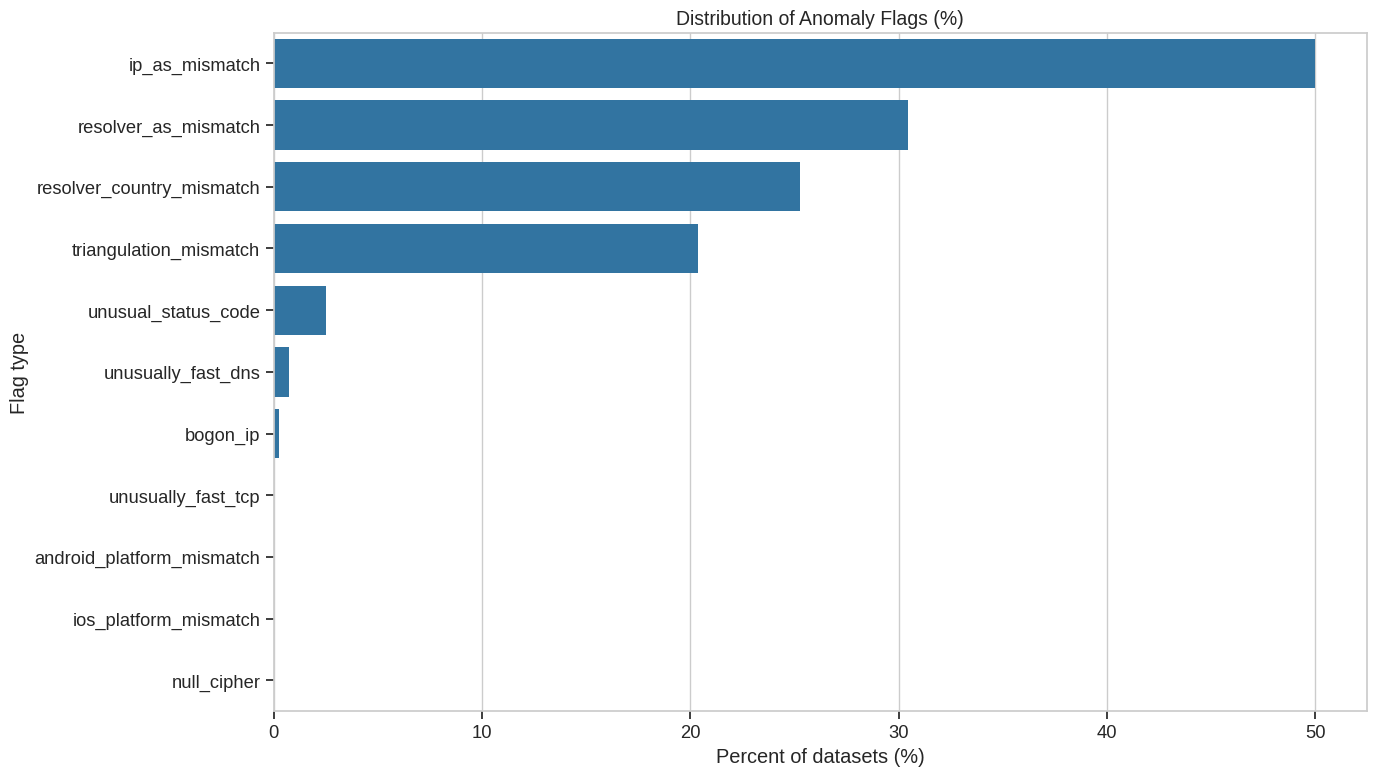

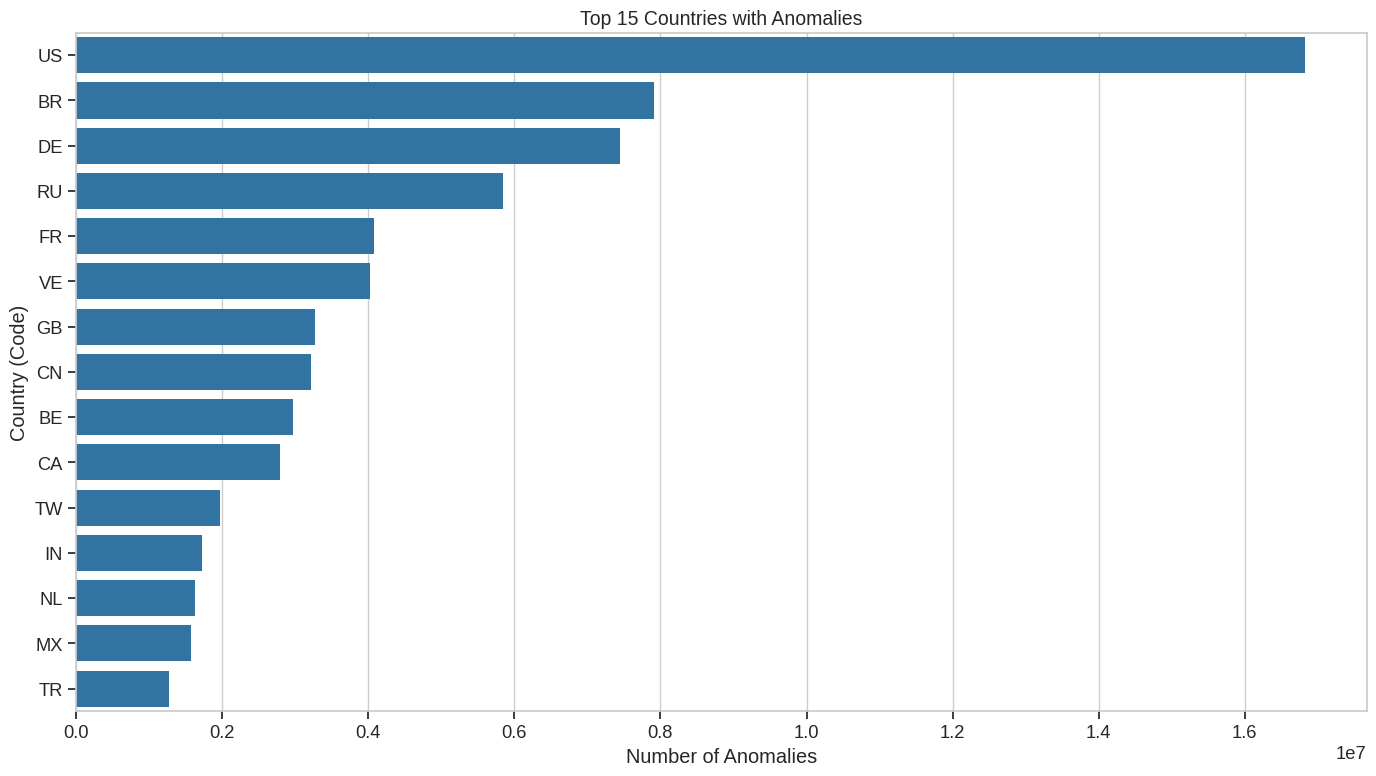

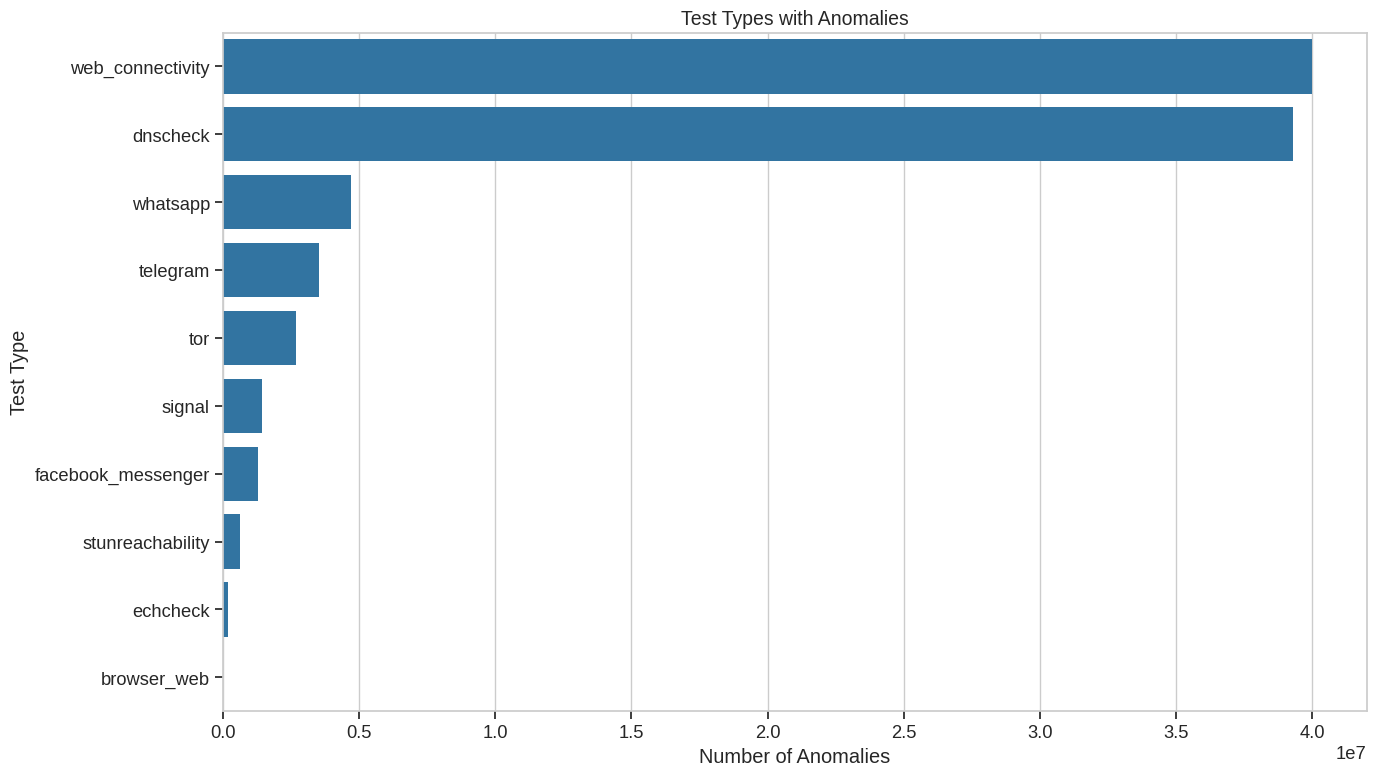

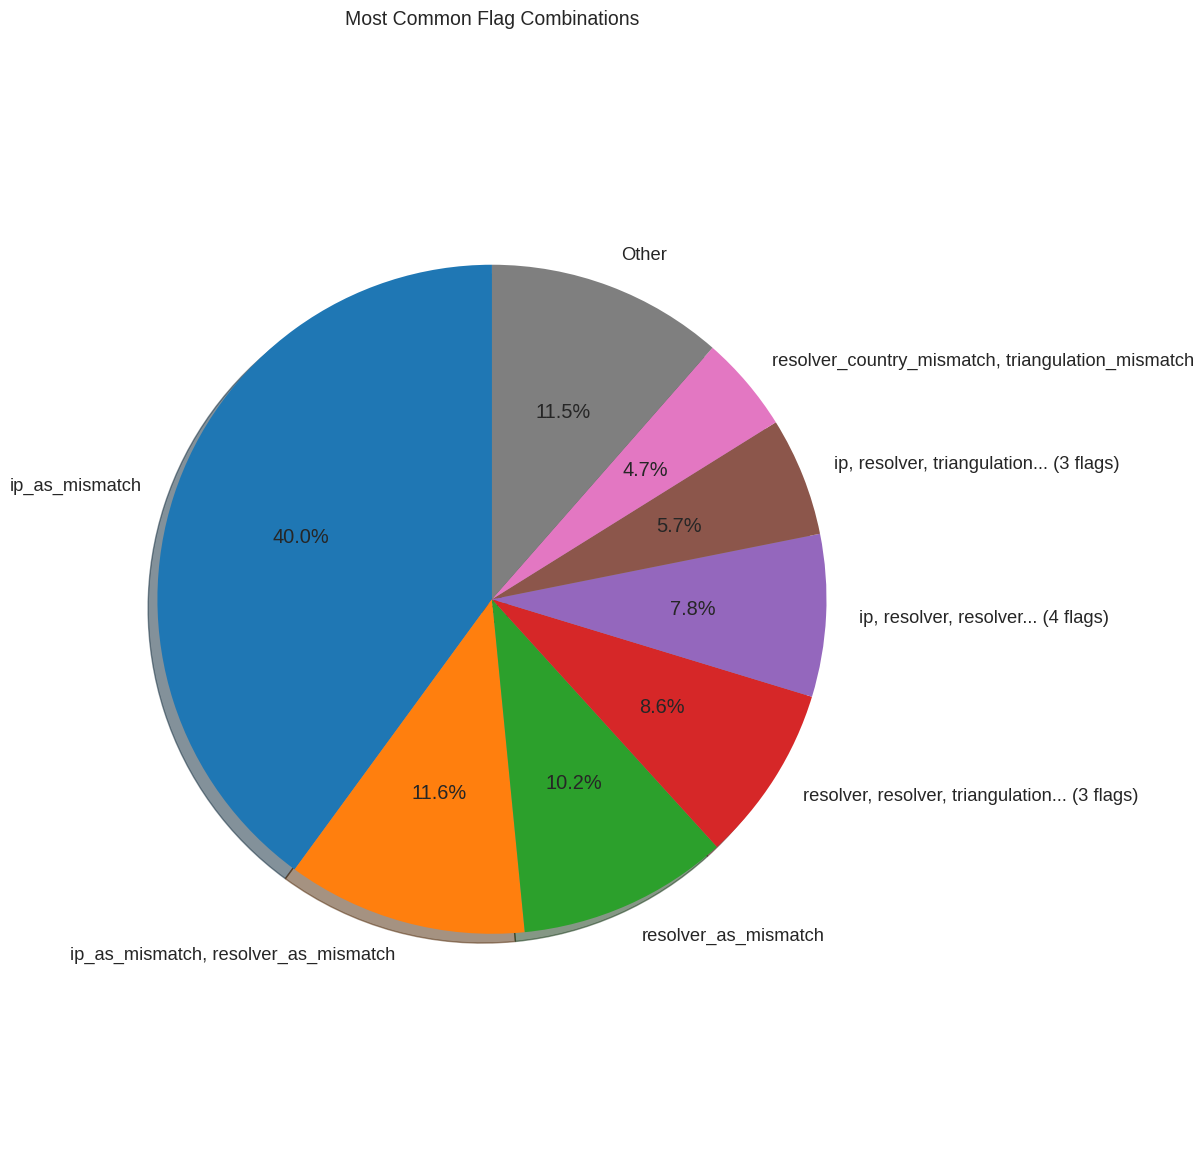

In [8]:
# Pfad zu deiner gereinigten Datei
csv_file = 'cleaned_ooni_data.csv'

# Führe die Analyse durch
results = analyze_flags_in_chunks(csv_file, chunk_size=1000000)

### 5. Summary of Data Cleaning Process

In this section, we performed the following data cleaning steps:

1. **Handled missing values**:
   - Dropped columns with extremely high (>40%) missing rates
   - Filled missing values in categorical columns with "unknown"
   - Retained columns with minimal missing data

2. **Normalized categorical variables**:
   - Standardized country codes to ISO 3166-1 alpha-2 format
   - Unified test names and types to consistent formats
   - Normalized network types to standard categories
   - Converted special null indicators (\\N) to proper NaN values

These cleaning steps ensure that our dataset is more consistent and ready for in-depth analysis. We've created a cleaning workflow that can be applied to the entire 88GB dataset in chunks, allowing us to process it efficiently without memory constraints.

Next, we'll proceed with exploratory data analysis to better understand patterns of internet blocking across different countries and services.

## 3. Analysis of Blocking Instances

In this section, we'll analyze the OONI measurements to categorize test results into three main groups:

1. **Confirmed Blocked**: Tests that have been confirmed as blocked based on specific fingerprints and known blocking patterns.
2. **Anomalies**: Tests that show signs of potential blocking but require further investigation.
3. **Accessible**: Tests that indicate no signs of blocking.

We'll develop methods to classify each measurement and then visualize the results to better understand the patterns of internet censorship in the dataset.

In [9]:
def categorize_blocking(chunk):
    """
    Categorize tests into Confirmed Blocked, Anomalies, or Accessible
    
    Adds a 'blocking' column with values: 'confirmed', 'anomaly', or 'accessible'
    """
    # Initialize the blocking column as 'accessible' (default)
    chunk['blocking'] = 'accessible'
    
    # Define conditions for confirmed blocking
    confirmed_conditions = []
    
    # HTTP-based confirmed blocking (specific status codes associated with censorship)
    if 'http_response_status_code' in chunk.columns:
        # HTTP 451 is specifically for legal restrictions/censorship
        confirmed_conditions.append(chunk['http_response_status_code'] == 451)
        
        # Check for HTTP failure patterns typical of blocking
        if 'http_failure' in chunk.columns:
            confirmed_conditions.append(
                (chunk['http_failure'].notna()) & 
                (chunk['http_failure'].str.contains('connection_refused|ssl_invalid|dns_nxdomain_error', 
                                                   case=False, na=False))
            )
    
    # DNS-based confirmed blocking
    if 'dns_failure' in chunk.columns:
        confirmed_conditions.append(
            (chunk['dns_failure'].notna()) & 
            (chunk['dns_failure'].str.contains('nxdomain|servfail', case=False, na=False))
        )
    
    # TLS-based confirmed blocking
    if 'tls_failure' in chunk.columns:
        confirmed_conditions.append(
            (chunk['tls_failure'].notna()) & 
            (chunk['tls_failure'].str.contains('handshake_failure|invalid_certificate', 
                                              case=False, na=False))
        )
    
    # Bogon IPs are a strong indicator of DNS poisoning/blocking
    if 'flag_bogon_ip' in chunk.columns:
        confirmed_conditions.append(chunk['flag_bogon_ip'] == True)
    
    # Apply confirmed blocking conditions
    if confirmed_conditions:
        chunk.loc[pd.concat(confirmed_conditions, axis=1).any(axis=1), 'blocking'] = 'confirmed'
    
    # Define conditions for anomalies (suspicious but not confirmed)
    anomaly_conditions = []
    
    # DNS resolver in different country can be suspicious
    if 'flag_resolver_country_mismatch' in chunk.columns:
        anomaly_conditions.append(chunk['flag_resolver_country_mismatch'] == True)
    
    # Triangulation mismatches often indicate proxying or interference
    if 'flag_triangulation_mismatch' in chunk.columns:
        anomaly_conditions.append(chunk['flag_triangulation_mismatch'] == True)
    
    # Unusual HTTP status codes that could indicate soft blocking
    if 'http_response_status_code' in chunk.columns:
        anomaly_conditions.append(
            chunk['http_response_status_code'].isin([403, 404, 502, 503, 504])
        )
    
    # Null cipher suite could indicate downgrade attacks
    if 'flag_null_cipher' in chunk.columns:
        anomaly_conditions.append(chunk['flag_null_cipher'] == True)
    
    # If record has the general anomaly flag and isn't already confirmed blocked
    if 'has_anomaly' in chunk.columns:
        anomaly_conditions.append(
            (chunk['has_anomaly'] == True) & (chunk['blocking'] != 'confirmed')
        )
    
    # Apply anomaly conditions (only if not already marked as confirmed)
    if anomaly_conditions:
        chunk.loc[
            (pd.concat(anomaly_conditions, axis=1).any(axis=1)) & 
            (chunk['blocking'] != 'confirmed'), 
            'blocking'
        ] = 'anomaly'
    
    # Everything else remains 'accessible'
    
    return chunk

def process_ooni_data_chunked(input_file, output_file, chunksize=1000000):
    """
    Process the already cleaned OONI data in chunks, categorize it, and save to a new file
    
    Args:
        input_file: Path to the cleaned OONI data CSV
        output_file: Path to save the categorized data
        chunksize: Number of rows to process in each chunk
    
    Returns:
        A dictionary with summary statistics
    """
    start_time = time.time()
    
    # Initialize counters and tracking variables
    total_rows = 0
    category_counter = Counter()
    country_categories = {}
    chunk_count = 0
    
    print(f"Processing {input_file} in chunks of {chunksize:,} rows...")
    
    # Set up the CSV writer for output
    for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
        if i % 10 == 0:
            elapsed = time.time() - start_time
            print(f"Processing chunk {i}, rows processed so far: {total_rows:,} ({elapsed:.1f}s elapsed)")
        
        # Categorize the chunk
        chunk = categorize_blocking(chunk)
        total_rows += len(chunk)
        chunk_count += 1
        
        # Update category counters
        chunk_categories = chunk['blocking'].value_counts()
        for category, count in chunk_categories.items():
            category_counter[category] += count
        
        # Track country-specific stats if available
        if 'probe_cc' in chunk.columns:
            country_counts = chunk.groupby(['probe_cc', 'blocking']).size().unstack(fill_value=0)
            
            for country, row in country_counts.iterrows():
                if country not in country_categories:
                    country_categories[country] = Counter()
                
                for category, count in row.items():
                    country_categories[country][category] += count
        
        # Write to the output file
        # First chunk: write with header
        if i == 0:
            chunk.to_csv(output_file, index=False, mode='w')
        # Subsequent chunks: append without header
        else:
            chunk.to_csv(output_file, index=False, header=False, mode='a')
    
    # Calculate processing time
    total_time = time.time() - start_time
    
    # Print summary statistics
    print("\n===== Blocking Categories Summary =====")
    print(f"Total records processed: {total_rows:,}")
    print(f"Processing time: {total_time:.2f} seconds")
    print(f"Average processing speed: {total_rows/total_time:.1f} records/second")
    
    total_count = sum(category_counter.values())
    print("\n=== Overall Category Distribution ===")
    for category, count in sorted(category_counter.items(), key=lambda x: x[1], reverse=True):
        percent = (count / total_count) * 100 if total_count > 0 else 0
        print(f"{category}: {count:,} records ({percent:.2f}%)")
    
    # Print top 10 countries by confirmed blocking
    if country_categories:
        print("\n=== Top 10 Countries by Confirmed Blocking ===")
        top_countries = sorted(
            [(country, counts.get('confirmed', 0)) for country, counts in country_categories.items()],
            key=lambda x: x[1], 
            reverse=True
        )[:10]
        
        for country, count in top_countries:
            total = sum(country_categories[country].values())
            percent = (count / total) * 100 if total > 0 else 0
            print(f"{country}: {count:,} confirmed blocked ({percent:.2f}% of country's {total:,} records)")
    
    print(f"\nCategorized data saved to {output_file}")
    
    return {
        'total_rows': total_rows,
        'categories': dict(category_counter),
        'country_data': {country: dict(counts) for country, counts in country_categories.items()},
        'processing_time': total_time
    }

In [12]:
# Pfad zur gereinigten OONI-Datendatei
input_file = "cleaned_ooni_data.csv"

# Pfad für die kategorisierte Ausgabedatei
output_file = "categorized_ooni_data.csv"

# Verarbeite die Daten
stats = process_ooni_data_chunked(input_file, output_file, chunksize=1000000)

Processing cleaned_ooni_data.csv in chunks of 1,000,000 rows...
Processing chunk 0, rows processed so far: 0 (7.6s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10, rows processed so far: 10,000,000 (328.9s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 20, rows processed so far: 20,000,000 (654.7s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 30, rows processed so far: 30,000,000 (981.3s elapsed)
Processing chunk 40, rows processed so far: 40,000,000 (1306.8s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 50, rows processed so far: 50,000,000 (1628.6s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 60, rows processed so far: 60,000,000 (1948.5s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70, rows processed so far: 70,000,000 (2269.2s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 80, rows processed so far: 80,000,000 (2589.4s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 90, rows processed so far: 90,000,000 (2917.1s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 100, rows processed so far: 100,000,000 (3246.6s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 110, rows processed so far: 110,000,000 (3576.8s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120, rows processed so far: 120,000,000 (3905.8s elapsed)


/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/171638846.py:111: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for


===== Blocking Categories Summary =====
Total records processed: 128,683,208
Processing time: 4182.22 seconds
Average processing speed: 30769.1 records/second

=== Overall Category Distribution ===
anomaly: 92,825,914 records (72.14%)
accessible: 34,333,535 records (26.68%)
confirmed: 1,523,759 records (1.18%)

=== Top 10 Countries by Confirmed Blocking ===
VE: 424,101 confirmed blocked (7.14% of country's 5,941,424 records)
US: 248,907 confirmed blocked (0.85% of country's 29,345,715 records)
DE: 122,017 confirmed blocked (1.18% of country's 10,363,353 records)
RU: 72,791 confirmed blocked (1.05% of country's 6,906,728 records)
BR: 71,723 confirmed blocked (0.75% of country's 9,523,111 records)
FR: 62,943 confirmed blocked (1.11% of country's 5,658,745 records)
CN: 46,790 confirmed blocked (1.41% of country's 3,309,104 records)
IR: 36,563 confirmed blocked (10.47% of country's 349,367 records)
GB: 34,745 confirmed blocked (0.74% of country's 4,719,190 records)
CA: 24,442 confirmed bl

In [13]:
def plot_blocking_categories(input_file, output_dir=None):
    """
    Create visualizations for blocking categories from the OONI data
    
    Args:
        input_file: Path to the categorized OONI data CSV
        output_dir: Directory to save plots (default: creates a 'plots' directory)
    """
    if output_dir is None:
        output_dir = Path('plots')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize aggregation dictionaries to collect data across chunks
    country_category_counts = {}
    category_totals = {'confirmed': 0, 'anomaly': 0, 'accessible': 0}
    category_by_date = {}
    top_blocked_domains = {}
    
    # Set up chunking parameters
    chunksize = 1000000  # Adjust based on your system's memory
    total_rows = 0
    
    print(f"Reading data from {input_file} in chunks...")
    
    # Process the file in chunks
    for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
        if i % 10 == 0:
            print(f"Processing chunk {i}...")
        
        # Count total records
        chunk_size = len(chunk)
        total_rows += chunk_size
        
        # Skip empty chunks
        if chunk_size == 0:
            continue
        
        # Ensure blocking and probe_cc columns exist
        if 'blocking' not in chunk.columns or 'probe_cc' not in chunk.columns:
            print("Warning: 'blocking' or 'probe_cc' column missing in chunk")
            continue
            
        # Aggregate by country and category
        country_counts = chunk.groupby(['probe_cc', 'blocking']).size().unstack(fill_value=0)
        
        # Update country_category_counts
        for country, row in country_counts.iterrows():
            if country not in country_category_counts:
                country_category_counts[country] = {'confirmed': 0, 'anomaly': 0, 'accessible': 0}
            
            for category in ['confirmed', 'anomaly', 'accessible']:
                if category in row:
                    country_category_counts[country][category] += row[category]
        
        # Update total counts
        category_counts = chunk['blocking'].value_counts()
        for category in ['confirmed', 'anomaly', 'accessible']:
            if category in category_counts:
                category_totals[category] += category_counts[category]
        
        # Aggregate by date if measurement_start_time exists
        if 'measurement_start_time' in chunk.columns:
            # Convert to datetime if it's not already
            if not pd.api.types.is_datetime64_any_dtype(chunk['measurement_start_time']):
                chunk['measurement_start_time'] = pd.to_datetime(chunk['measurement_start_time'], errors='coerce')
            
            # Extract date part
            chunk['date'] = chunk['measurement_start_time'].dt.date
            
            # Count by date and category
            date_counts = chunk.groupby(['date', 'blocking']).size().unstack(fill_value=0)
            
            # Update date aggregation
            for date, row in date_counts.iterrows():
                if date not in category_by_date:
                    category_by_date[date] = {'confirmed': 0, 'anomaly': 0, 'accessible': 0}
                
                for category in ['confirmed', 'anomaly', 'accessible']:
                    if category in row:
                        category_by_date[date][category] += row[category]
        
        # Collect domain blocking stats if input_url exists
        if 'input' in chunk.columns and chunk['blocking'].isin(['confirmed', 'anomaly']).any():
            blocked_domains = chunk[chunk['blocking'].isin(['confirmed', 'anomaly'])].groupby('input')['blocking'].count()
            
            for domain, count in blocked_domains.items():
                if domain in top_blocked_domains:
                    top_blocked_domains[domain] += count
                else:
                    top_blocked_domains[domain] = count
    
    print(f"Processed {total_rows} rows in total")
    
    # Create dataframes from the aggregated data
    df_country = pd.DataFrame.from_dict(country_category_counts, orient='index')
    df_country = df_country.fillna(0).sort_values(by=['confirmed', 'anomaly'], ascending=False)
    
    if category_by_date:
        df_date = pd.DataFrame.from_dict(category_by_date, orient='index')
        df_date = df_date.fillna(0).sort_index()
    
    if top_blocked_domains:
        df_domains = pd.DataFrame.from_dict(top_blocked_domains, orient='index', 
                                           columns=['count']).sort_values('count', ascending=False)
    
    # 1. Create stacked bar chart by country (top 20 countries)
    print("Creating country-wise blocking charts...")
    plt.figure(figsize=(15, 10))
    
    # Select top 20 countries with most blocking
    top_countries = df_country.head(20)
    
    # Calculate percentages for each category within each country
    country_totals = top_countries.sum(axis=1)
    country_percentages = top_countries.div(country_totals, axis=0) * 100
    
    # Create stacked bar chart with percentages
    ax = country_percentages.plot(kind='bar', stacked=True, figsize=(15, 10),
                                 color=['#ff5555', '#ffaa55', '#55aa55'])
    
    plt.title('Blocking Categories by Country (Top 20, Percentage)', fontsize=16)
    plt.xlabel('Country Code', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/blocking_by_country_percent.png", dpi=300)
    plt.close()
    
    # 2. Create absolute numbers stacked bar chart
    plt.figure(figsize=(15, 10))
    top_countries.plot(kind='bar', stacked=True, figsize=(15, 10),
                      color=['#ff5555', '#ffaa55', '#55aa55'])
    
    plt.title('Blocking Categories by Country (Top 20, Absolute Numbers)', fontsize=16)
    plt.xlabel('Country Code', fontsize=14)
    plt.ylabel('Number of Measurements', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/blocking_by_country_absolute.png", dpi=300)
    plt.close()
    
    # 3. Create pie chart for overall distribution
    print("Creating overall category distribution chart...")
    plt.figure(figsize=(10, 10))
    plt.pie([category_totals['confirmed'], category_totals['anomaly'], category_totals['accessible']], 
            labels=['Confirmed', 'Anomaly', 'Accessible'],
            autopct='%1.1f%%',
            colors=['#ff5555', '#ffaa55', '#55aa55'],
            explode=(0.1, 0.05, 0),
            startangle=90,
            shadow=True)
    
    plt.title('Overall Distribution of Blocking Categories', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/overall_distribution_pie.png", dpi=300)
    plt.close()
    
    # 4. If we have time-based data, create a time series plot
    if category_by_date:
        print("Creating time series plot...")
        plt.figure(figsize=(15, 8))
        df_date.plot(figsize=(15, 8), color=['#ff5555', '#ffaa55', '#55aa55'])
        
        plt.title('Blocking Categories Over Time', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Number of Measurements', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Category')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/blocking_over_time.png", dpi=300)
        plt.close()
        
        # 5. Create stacked area chart for time series
        plt.figure(figsize=(15, 8))
        df_date.plot.area(figsize=(15, 8), stacked=True, alpha=0.7,
                         color=['#ff5555', '#ffaa55', '#55aa55'])
        
        plt.title('Blocking Categories Over Time (Stacked)', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Number of Measurements', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(title='Category')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/blocking_over_time_stacked.png", dpi=300)
        plt.close()
    
    # 6. If we have domain data, create top blocked domains chart
    if top_blocked_domains:
        print("Creating top blocked domains chart...")
        plt.figure(figsize=(15, 10))
        
        # Plot top 20 blocked domains
        top_domains = df_domains.head(20)
        ax = top_domains.plot(kind='barh', figsize=(15, 10), color='#ff7777')
        
        plt.title('Top 20 Blocked Domains', fontsize=16)
        plt.xlabel('Number of Blocking Measurements', fontsize=14)
        plt.ylabel('Domain', fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Add value labels
        for i, v in enumerate(top_domains['count']):
            ax.text(v + 0.1, i, str(v), va='center')
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/top_blocked_domains.png", dpi=300)
        plt.close()
    
    # 7. Create a heatmap of top countries vs. categories
    print("Creating country category heatmap...")
    plt.figure(figsize=(12, 10))
    
    # Normalize data for the heatmap
    heatmap_data = top_countries.copy()
    for col in heatmap_data.columns:
        heatmap_data[col] = heatmap_data[col] / heatmap_data[col].max()
    
    sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', fmt='.2f', linewidths=.5)
    plt.title('Normalized Blocking Intensity by Country and Category', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/country_category_heatmap.png", dpi=300)
    plt.close()
    
    print(f"All plots saved to {output_dir} directory")
    
    return {
        'country_data': df_country,
        'total_data': category_totals,
        'time_data': df_date if category_by_date else None,
        'domain_data': df_domains if top_blocked_domains else None
    }

In [14]:
input_file = "categorized_ooni_data.csv"
results = plot_blocking_categories(input_file)
    
# Print summary statistics
print("\n===== Overall Category Distribution =====")
total = sum(results['total_data'].values())
for category, count in results['total_data'].items():
    percent = (count / total) * 100
    print(f"{category}: {count:,} records ({percent:.2f}%)")
    
print("\n===== Top 10 Countries by Confirmed Blocking =====")
top10 = results['country_data'].sort_values(by='confirmed', ascending=False).head(10)
print(top10)

Reading data from categorized_ooni_data.csv in chunks...
Processing chunk 0...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 20...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i

Processing chunk 30...
Processing chunk 40...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i

Processing chunk 50...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, c

Processing chunk 60...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i

Processing chunk 80...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, c

Processing chunk 90...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, c

Processing chunk 100...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 110...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120...


/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/596524599.py:28: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, c

Processed 128683208 rows in total
Creating country-wise blocking charts...
Creating overall category distribution chart...
Creating time series plot...
Creating top blocked domains chart...
Creating country category heatmap...
All plots saved to plots directory

===== Overall Category Distribution =====
confirmed: 1,523,759 records (1.18%)
anomaly: 92,825,914 records (72.14%)
accessible: 34,333,535 records (26.68%)

===== Top 10 Countries by Confirmed Blocking =====
    confirmed   anomaly  accessible
VE     424101   3765131     1752192
US     248907  16754752    12342056
DE     122017   7404544     2836792
RU      72791   5788515     1045422
BR      71723   7855301     1596087
FR      62943   4048725     1547077
CN      46790   3167452       94862
IR      36563    213991       98813
GB      34745   3259963     1424482
CA      24442   2774886     1193171


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

### Confidence Assessment

In [4]:
def assess_confidence(input_file, output_file, chunksize=500000):
    """
    Perform confidence assessment on categorized OONI data
    
    Args:
        input_file: Path to the categorized OONI data CSV
        output_file: Path to save the confidence-assessed data
        chunksize: Number of rows to process in each chunk
    """
    print(f"Performing confidence assessment on {input_file} in chunks...")
    
    # First pass: Gather statistics for confidence calculation
    # We need to count occurrences across countries for the same domains
    domain_country_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    domain_global_stats = defaultdict(lambda: defaultdict(int))
    country_anomaly_baseline = defaultdict(lambda: defaultdict(int))
    total_by_country = defaultdict(int)
    
    # First pass to gather statistics
    print("First pass: Gathering cross-country statistics...")
    for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
        if i % 10 == 0:
            print(f"Processing chunk {i} for statistics...")
        
        if 'input' not in chunk.columns or 'probe_cc' not in chunk.columns:
            print("Warning: Required columns 'input' or 'probe_cc' missing")
            continue
        
        # Group by domain (input), country, and blocking category
        for _, row in chunk.iterrows():
            domain = row.get('input', 'unknown')
            country = row.get('probe_cc', 'unknown')
            blocking = row.get('blocking', 'accessible')
            
            # Skip if essential data is missing
            if domain == 'unknown' or country == 'unknown':
                continue
                
            # Count occurrences by domain, country, and blocking status
            domain_country_stats[domain][country][blocking] += 1
            
            # Track global stats for each domain
            domain_global_stats[domain][blocking] += 1
            
            # Track country-level anomaly patterns
            if blocking != 'accessible':
                # Record specific anomaly types if present
                for anomaly_type in ['flag_bogon_ip', 'dns_failure', 'http_failure', 'tls_failure']:
                    if anomaly_type in row and row[anomaly_type]:
                        country_anomaly_baseline[country][anomaly_type] += 1
            
            # Count total tests by country
            total_by_country[country] += 1
    
    # Calculate country anomaly baselines (how common each anomaly is in each country)
    country_anomaly_rates = {}
    for country, anomalies in country_anomaly_baseline.items():
        country_anomaly_rates[country] = {
            anomaly: count / total_by_country[country] if total_by_country[country] > 0 else 0
            for anomaly, count in anomalies.items()
        }
    
    # Second pass: Calculate and assign confidence scores
    print("\nSecond pass: Calculating confidence scores...")
    
    # Open output file for writing in chunks
    first_chunk = True
    
    for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
        if i % 10 == 0:
            print(f"Processing chunk {i} for confidence scoring...")
        
        # Add a confidence score column
        chunk['confidence_score'] = 0.5  # Default neutral score
        
        # Calculate confidence for each row
        for idx, row in chunk.iterrows():
            domain = row.get('input', 'unknown')
            country = row.get('probe_cc', 'unknown')
            blocking = row.get('blocking', 'accessible')
            
            # Skip accessible content or missing data
            if blocking == 'accessible' or domain == 'unknown' or country == 'unknown':
                chunk.at[idx, 'confidence_score'] = 0.0  # No confidence needed for accessible
                continue
            
            # Start with base confidence from the categorization
            confidence = 0.5
            if blocking == 'confirmed':
                confidence = 0.7  # Higher base confidence for confirmed blocking
            elif blocking == 'anomaly':
                confidence = 0.3  # Lower base confidence for anomalies
            
            # Factor 1: Geo-differentiation
            # If this domain has problems mainly in this country but works elsewhere
            countries_with_domain = sum(1 for c in domain_country_stats[domain] 
                                     if sum(domain_country_stats[domain][c].values()) > 0)
            
            if countries_with_domain >= 3:  # Only if we have data from multiple countries
                # Calculate blocking rate for this domain in this country
                country_block_rate = (
                    (domain_country_stats[domain][country].get('confirmed', 0) + 
                     domain_country_stats[domain][country].get('anomaly', 0)) / 
                    sum(domain_country_stats[domain][country].values())
                    if sum(domain_country_stats[domain][country].values()) > 0 else 0
                )
                
                # Calculate blocking rate for this domain in other countries
                other_countries_tests = 0
                other_countries_blocked = 0
                
                for other_country, stats in domain_country_stats[domain].items():
                    if other_country != country:
                        other_countries_tests += sum(stats.values())
                        other_countries_blocked += stats.get('confirmed', 0) + stats.get('anomaly', 0)
                
                other_block_rate = (
                    other_countries_blocked / other_countries_tests
                    if other_countries_tests > 0 else 0
                )
                
                # If this country blocks the domain much more than others, increase confidence
                if country_block_rate > 0 and country_block_rate > (other_block_rate * 2):
                    geo_diff_boost = min(0.3, country_block_rate - other_block_rate)
                    confidence += geo_diff_boost
                    
                    # Additional boost if this is the only country blocking this domain
                    if other_block_rate == 0 and country_block_rate > 0.5:
                        confidence += 0.1
            
            # Factor 2: Consistency across tests
            total_tests = sum(domain_country_stats[domain][country].values())
            if total_tests >= 3:  # Only consider if we have multiple tests
                blocked_tests = (domain_country_stats[domain][country].get('confirmed', 0) + 
                               domain_country_stats[domain][country].get('anomaly', 0))
                consistency_score = blocked_tests / total_tests if total_tests > 0 else 0
                
                # Boost confidence based on consistency
                confidence += consistency_score * 0.2
            
            # Factor 3: Multiple anomaly indicators in the same test
            anomaly_count = 0
            for anomaly_flag in ['flag_bogon_ip', 'dns_failure', 'http_failure', 'tls_failure']:
                if anomaly_flag in row and row[anomaly_flag]:
                    anomaly_count += 1
            
            if anomaly_count >= 2:
                confidence += 0.1 * min(anomaly_count - 1, 3)  # Up to 3 additional indicators
            
            # Factor 4: Compare with country baseline for this anomaly type
            # If this anomaly is rare in this country but happens for this domain, boost confidence
            for anomaly_type in ['flag_bogon_ip', 'dns_failure', 'http_failure', 'tls_failure']:
                if anomaly_type in row and row[anomaly_type] and country in country_anomaly_rates:
                    # If this anomaly is relatively rare in this country (<5% of tests)
                    if country_anomaly_rates[country].get(anomaly_type, 0) < 0.05:
                        confidence += 0.1
            
            # Cap confidence between 0 and 1
            confidence = max(0.0, min(1.0, confidence))
            
            # Update the confidence score in the dataframe
            chunk.at[idx, 'confidence_score'] = confidence
        
        # Add a confidence category column
        bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        chunk['confidence_category'] = pd.cut(
            chunk['confidence_score'], 
            bins=bins, 
            labels=labels,
            include_lowest=True
        )
        
        # Write to output file
        if first_chunk:
            chunk.to_csv(output_file, index=False, mode='w')
            first_chunk = False
        else:
            chunk.to_csv(output_file, index=False, header=False, mode='a')
    
    print(f"Confidence assessment complete. Results saved to {output_file}")
    
    return {
        'domain_country_stats': domain_country_stats,
        'domain_global_stats': domain_global_stats,
        'country_anomaly_rates': country_anomaly_rates
    }


def visualize_confidence_results(input_file, output_dir='.', chunksize=500000, sample_rate=1):
    """
    Create visualizations of confidence assessment results with memory optimization
    
    Args:
        input_file: Path to the confidence-assessed data
        output_dir: Directory to save visualizations
        chunksize: Size of chunks to process
        sample_rate: Fraction of data to sample for visualizations (0.1 = 10%)
    """
    import os
    import random
    from collections import Counter
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"Creating visualizations in {output_dir} with sampling rate {sample_rate:.1%}...")
    
    # Use counters instead of storing all values
    confidence_score_bins = Counter()
    country_confidence = defaultdict(Counter)
    category_confidence = defaultdict(Counter)
    
    # Map float confidence scores to categorical bins for histograms
    def score_to_bin(score):
        bin_size = 0.05  # 20 bins from 0 to 1
        return round(score / bin_size) * bin_size
    
    # Process the data in chunks with sampling
    print("Sampling data for visualizations...")
    for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
        if i % 10 == 0:
            print(f"Processing chunk {i} for visualization data...")
        
        # Apply sampling to reduce memory usage
        if sample_rate < 1.0:
            chunk = chunk.sample(frac=sample_rate)
        
        # Only look at rows with blocking
        blocked_data = chunk[chunk['blocking'].isin(['confirmed', 'anomaly'])]
        
        if len(blocked_data) == 0:
            continue
            
        # Count confidence score distributions
        for score in blocked_data['confidence_score']:
            if not pd.isna(score):
                confidence_score_bins[score_to_bin(score)] += 1
        
        # Aggregate country data without storing full dataframes
        for _, row in blocked_data.iterrows():
            country = row.get('probe_cc')
            conf_cat = row.get('confidence_category')
            blocking = row.get('blocking')
            
            if pd.notna(country) and pd.notna(conf_cat):
                country_confidence[country][conf_cat] += 1
                
            if pd.notna(blocking) and pd.notna(conf_cat):
                category_confidence[blocking][conf_cat] += 1
    
    print("Creating visualizations...")
    
    # 1. Overall confidence score distribution
    if confidence_score_bins:
        plt.figure(figsize=(10, 6))
        
        # Convert counter to series for plotting
        score_dist = pd.Series(confidence_score_bins)
        
        # Plot histogram from the binned data
        score_dist.sort_index().plot(kind='bar')
        
        plt.title('Distribution of Confidence Scores for Blocked Content', fontsize=14)
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/confidence_distribution.png", dpi=300)
        plt.close()
    
    # 2. Top countries by high confidence
    if country_confidence:
        country_data = []
        for country, conf_counts in country_confidence.items():
            high_conf = conf_counts.get('High', 0) + conf_counts.get('Very High', 0)
            total = sum(conf_counts.values())
            
            if total > 0:  # Only include countries with data
                country_data.append({
                    'country': country,
                    'high_confidence': high_conf,
                    'total': total
                })
        
        # Only create plot if we have data
        if country_data:
            country_df = pd.DataFrame(country_data)
            
            # Only show top 10 countries with most high confidence blocks
            top_countries = country_df.sort_values('high_confidence', ascending=False).head(10)
            
            if len(top_countries) > 0:
                plt.figure(figsize=(12, 8))
                
                # Simple bar plot instead of seaborn
                plt.bar(top_countries['country'], top_countries['high_confidence'])
                
                plt.title('Top 10 Countries by High/Very High Confidence Blocking', fontsize=14)
                plt.xlabel('Country Code', fontsize=12)
                plt.ylabel('Number of High Confidence Blocks', fontsize=12)
                plt.xticks(rotation=45)
                plt.grid(axis='y', alpha=0.3)
                
                # Add value labels
                for i, (_, row) in enumerate(top_countries.iterrows()):
                    plt.text(i, row['high_confidence'] + 5, str(int(row['high_confidence'])), 
                             ha='center', va='bottom')
                
                plt.tight_layout()
                plt.savefig(f"{output_dir}/top_countries_high_confidence.png", dpi=300)
                plt.close()
    
    # 3. Confidence by blocking category
    if category_confidence:
        category_data = []
        for blocking, conf_counts in category_confidence.items():
            for conf_level, count in conf_counts.items():
                category_data.append({
                    'blocking_category': blocking,
                    'confidence_level': conf_level,
                    'count': count
                })
        
        if category_data:
            category_df = pd.DataFrame(category_data)
            
            # Use pivot table for simpler plotting
            pivot_data = category_df.pivot_table(
                index='blocking_category', 
                columns='confidence_level', 
                values='count',
                fill_value=0
            )
            
            # Ensure columns are in correct order
            ordered_cols = [col for col in ['Very Low', 'Low', 'Medium', 'High', 'Very High'] 
                          if col in pivot_data.columns]
            pivot_data = pivot_data[ordered_cols]
            
            # Plot stacked bar chart
            plt.figure(figsize=(10, 6))
            pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), 
                          colormap='YlOrRd_r')
            
            plt.title('Confidence Distribution by Blocking Category', fontsize=14)
            plt.xlabel('Blocking Category', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.legend(title='Confidence Level')
            plt.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f"{output_dir}/confidence_by_category.png", dpi=300)
            plt.close()
    
    print(f"Visualizations saved to {output_dir}")

In [16]:
input_file = "categorized_ooni_data.csv"
output_file = "confidence_assessed_data.csv"
output_dir = "plots"
    
# Run confidence assessment
stats = assess_confidence(input_file, output_file)
    
# Create visualizations
visualize_confidence_results(output_file, output_dir)

Performing confidence assessment on categorized_ooni_data.csv in chunks...
First pass: Gathering cross-country statistics...
Processing chunk 0 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 20 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 30 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 40 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 50 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 60 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 80 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 90 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 100 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 110 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120 for statistics...
Processing chunk 130 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 140 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 150 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 160 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.

Processing chunk 170 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 180 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 190 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 200 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 210 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 220 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 230 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 240 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 250 for statistics...


/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (30,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:21: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):



Second pass: Calculating confidence scores...
Processing chunk 0 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 20 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 30 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 40 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 50 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 60 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 80 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 90 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 100 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 110 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120 for confidence scoring...
Processing chunk 130 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 140 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 150 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 160 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.

Processing chunk 170 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 180 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 190 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 200 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 210 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 220 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for

Processing chunk 230 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 240 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  

Processing chunk 250 for confidence scoring...


/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (30,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:69: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Confidence assessment complete. Results saved to confidence_assessed_data.csv
Aggregating data for visualization...
Processing chunk 0...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.


Processing chunk 20...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 30...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 40...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.


Processing chunk 50...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 60...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 80...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 90...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 100...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 110...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120...
Processing chunk 130...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 140...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 150...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 160...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=F

Processing chunk 170...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.


Processing chunk 180...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 190...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.


Processing chunk 200...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 210...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 220...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.


Processing chunk 230...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 240...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=Fals

Processing chunk 250...


/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (30,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_4392/3965349476.py:206: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Creating visualizations...


: 

In [5]:
output_file = "confidence_assessed_data.csv"
output_dir = "plots"

# Create visualizations
visualize_confidence_results(output_file, output_dir)

Creating visualizations in plots with sampling rate 100.0%...
Sampling data for visualizations...
Processing chunk 0 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 10 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fa

Processing chunk 20 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 30 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 40 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fa

Processing chunk 50 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 60 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 70 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32,41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 80 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 90 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 100 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 110 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 120 for visualization data...
Processing chunk 130 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 140 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32,64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 150 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 160 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_mem

Processing chunk 170 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fa

Processing chunk 180 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 190 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fa

Processing chunk 200 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 210 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 220 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=Fa

Processing chunk 230 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Processing chunk 240 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (41,64) have mixed types. Specify dtype option on import or set low_memory

Processing chunk 250 for visualization data...


/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (30,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):
/tmp/ipykernel_12157/1635402754.py:221: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize)):


Creating visualizations...
Visualizations saved to plots


<Figure size 1000x600 with 0 Axes>